<a href="https://colab.research.google.com/github/armandossrecife/my_validation3/blob/main/my_analysis_cassandra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup do Ambiente de Análise

In [1]:
!rm -rf *.log
!rm -rf *.txt
!rm -rf *.xlsx
!rm -rf my_issues
!rm -rf cassandra

In [2]:
print('Install Pydriller.')
!pip install pydriller > install_pydriller.log
print('Install gitpython.')
!pip3 install gitpython > install_gitpython.log
print('Install Jira Python lib.')
!pip install jira > install_jira_python.log
print('Install SQLite in Linux')
!sudo apt install -y sqlite3 > install_sqlite.log
print('All depenpencies installed!')
!cat *.log > install.log
print('Details in install.log')

Install Pydriller.
Install gitpython.
Install Jira Python lib.
Install SQLite in Linux


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
All depenpencies installed!
Details in install.log


## Importa bibliotecas necessárias

In [87]:
import os
from datetime import datetime, timedelta
import tqdm
from pydriller import Repository
from jira import JIRA
import pandas as pd
import re
import scipy.stats as stats
import random
import shutil
import time
from matplotlib import pyplot
import cv2

## Variáveis Globais

In [149]:
my_repository = 'cassandra'
url_to_repository = 'https://github.com/apache/cassandra.git'
os.environ['MY_REPOSITORY'] = url_to_repository

JIRA_SERVER = 'https://issues.apache.org/jira'
ISSUE_TRACKER_PROJECT = 'CASSANDRA'

# Credentials
os.environ['USERNAME'] = ''
os.environ['PASSWORD'] = ''
username = os.environ.get('USERNAME')
password = os.environ.get('PASSWORD')

path_to_repository = 'cassandra'

list_figures = []
list_titles = []

lista_arquivos_criticos = ['StorageService.java', 'ColumnFamilyStore.java','DatabaseDescriptor.java','CompactionManager.java','StorageProxy.java','SSTableReader.java','Config.java','CassandraDaemon.java','SelectStatement.java','SinglePartitionReadCommand.java','NodeProbe.java','MessagingService.java']

## Clona o Repositório

In [5]:
print(f'Clona o repositório : {url_to_repository}')
!git clone $MY_REPOSITORY

Clona o repositório : https://github.com/apache/cassandra.git
Cloning into 'cassandra'...
remote: Enumerating objects: 408114, done.
remote: Counting objects: 100% (554/554), done.
remote: Compressing objects: 100% (439/439), done.
remote: Total 408114 (delta 124), reused 369 (delta 62), pack-reused 407560
Receiving objects: 100% (408114/408114), 409.91 MiB | 15.78 MiB/s, done.
Resolving deltas: 100% (238257/238257), done.
Updating files: 100% (6482/6482), done.


## Funções de apoio

In [141]:
def get_all_commits_by_range(initial_date, final_date, repository_name):
  """Extracts information from a date range of commits
  Args:
      initial_date: inicial date of commits
      final_date: final date of commits
  Returns:
        A dictionary of commits, where the keys are the commit hashes and the
        values are tuples containing the commit message, commit's date, commit's line, commit's file, a list of files modified in the commit, a list of all diffs from modified files
  """
  dict_commit_modified_files = {}
  print('Wait...')
  my_traverser_commits = Repository(repository_name, since=initial_date, to=final_date).traverse_commits()
  total_commits = len(list(my_traverser_commits))
  try:
    for commit in tqdm.tqdm(Repository(repository_name, since=initial_date, to=final_date).traverse_commits(), total=total_commits, desc="Progress commit anlysis"):
      list_of_modified_files = []
      list_dict_of_diff_modified_files = []
      for m in commit.modified_files:
        dict_m_diff = {}
        if m is not None:
          list_of_modified_files.append(m.filename)
          dict_m_diff[m.filename] = m.diff
          list_dict_of_diff_modified_files.append(dict_m_diff)
      data_commit = str(commit.committer_date.day) + '/' + str(commit.committer_date.month) + '/' + str(commit.committer_date.year)
      element = commit.msg, data_commit, commit.lines, commit.files, list_of_modified_files, list_dict_of_diff_modified_files
      dict_commit_modified_files[commit.hash] = element
  except Exception as ex:
    print(f'Erro during travesse commits: {str(ex)}')
  return dict_commit_modified_files, total_commits

def get_commits_by_range_and_critical_files(initial_date, final_date, critical_files, repository_name):
  """Extracts information from a date range of commits, focusing on critical files.
  Args:
      initial_date: inicial date of commits
      final_date: final date of commits
      critical_files: A list of critical file paths. ex: ['StorageService.java', 'ColumnFamilyStore.java']
  Returns:
        A dictionary of commits, where the keys are the commit hashes and the
        values are tuples containing the commit message, commits's date, commit's line, commit's file, a list of critical files modified in the commit, a list_of_modified_files, a dictionary of diff [filename]:filename.diff, a list of all diffs from modified files
        commit.msg, data_commit, commit.lines, commit.files, list_of_critical_files_modified, list_of_modified_files, list_dict_of_diff_files, list_dict_of_diff_modified_files
  """

  dict_commit_modified_files = {}
  print('Wait...')
  my_traverser_commits = Repository(repository_name, since=initial_date, to=final_date).traverse_commits()
  total_commits = len(list(my_traverser_commits))
  try:
    for commit in tqdm.tqdm(Repository(repository_name, since=initial_date, to=final_date).traverse_commits(), total=total_commits, desc="Progress critical files commit anlysis"):
      list_of_critical_files_modified = []
      list_of_modified_files = []
      list_dict_of_diff_files = []
      list_dict_of_diff_modified_files = []
      for m in commit.modified_files:
        dict_diff_file = {}
        list_of_modified_files.append(m.filename)
        list_dict_of_diff_modified_files.append(m.diff)
        if m.filename in critical_files:
          list_of_critical_files_modified.append(m.filename)
          dict_diff_file[m.filename] = m.diff
          list_dict_of_diff_files.append(dict_diff_file)
      if len(list_of_critical_files_modified) > 0:
        data_commit = str(commit.committer_date.day) + '/' + str(commit.committer_date.month) + '/' + str(commit.committer_date.year)
        element = commit.msg, data_commit, commit.lines, commit.files, list_of_critical_files_modified, list_of_modified_files, list_dict_of_diff_files, list_dict_of_diff_modified_files
        dict_commit_modified_files[commit.hash] = element
  except Exception as ex:
    print(f'Erro during travesse commits: {str(ex)}')
  return dict_commit_modified_files, total_commits

class JiraIssue:
  def __init__(self, key, summary, issue_type, status, priority, description, comments, created_date=None, updated_date=None, resolved_date=None):
    self.key = key
    self.summary = summary
    self.issue_type = issue_type
    self.status = status
    self.priority = priority
    self.description = description
    self.comments = comments
    self.created_date = created_date
    self.updated_date = updated_date
    self.resolved_date = resolved_date

  def get_comments(self):
    return self.comments

  def __str__(self):
    return (f'Key: {self.key}, Summary: {self.summary}, Type: {self.issue_type}, Status: {self.status}')

class JiraIssues:
  def __init__(self,project, issues):
    self.project = project
    self.issues = issues

  def add_issue(self, issue):
    self.issues.append(issue)

  def get_issues(self) -> list:
    return self.issues

  def update_issues(self, issues):
    self.issues = issues

  def __str__(self):
    str_issues = ""
    for issue in self.get_issues():
      str_issues = str_issues + str(issue)
      str_issues = str_issues + ', '
    str_issues = '[' + str_issues + ']'
    return (f'Project: {self.project}, Qdt of issues: {len(self.issues)}, Issues: {str_issues}')

# Classe de utilidades para manipular o servidor Jira
class JiraUtils:
  def __init__(self, project, jira_instance):
    self.project = project
    self.jira_jira_instance = jira_instance

  def generate_intervals_between_dates(self, date1: tuple, date2: tuple, distance=120) -> list:
    start_date = datetime(date1[0], date1[1], date1[2])
    end_date = datetime(date2[0], date2[1], date2[2])
    interval_days = distance
    # Initialize a list to store the intervals
    intervals = []
    # Initialize the current date as the start date
    current_date = start_date
    # Loop to generate intervals until the current date is less than or equal to the end date
    while current_date < end_date:
        interval = (current_date, current_date + timedelta(days=interval_days - 1))
        intervals.append(interval)
        current_date += timedelta(days=interval_days)
    return intervals

  def convert_interval_dates(self, dates: list) -> list:
    list_interval_dates = []
    for each in dates:
      date1 = each[0]
      # Convert the date to a string in the format "YYYY/MM/DD".
      str_date1 = date1.strftime("%Y/%m/%d")
      date2 = each[1]
      str_date2 = date2.strftime("%Y/%m/%d")
      elemento = str_date1, str_date2
      list_interval_dates.append(elemento)
    return list_interval_dates

  def generate_list_of_sentences(self, dates: list) -> list:
    lista_sentencas = []
    for each in dates:
      str_date1 = each[0].strftime("%Y/%m/%d")
      str_date2 = each[1].strftime("%Y/%m/%d")
      sentenca = f'project={self.project.upper()} and created>="{str_date1}" and created<="{str_date2}"'
      lista_sentencas.append(sentenca)
    return lista_sentencas

  def get_list_of_block_issues_by_dates(self,date1, date2, distance=120) -> list:
    print('Aguarde...')
    t1 = datetime.now()
    list_of_dates = self.generate_intervals_between_dates(date1,date2,distance)
    lista_sentencas = self.generate_list_of_sentences(list_of_dates)
    lista_bloco_issues_by_date = []
    total_items = len(lista_sentencas)
    i = 0
    iterable_lista_sentencas = tqdm.tqdm(lista_sentencas, total=total_items)
    for each in iterable_lista_sentencas:
      issues_by_date_temp = self.jira_jira_instance.search_issues(each,maxResults=1000)
      print(f'Range: {each}, qtd issues: {len(issues_by_date_temp)}')
      lista_bloco_issues_by_date.append(issues_by_date_temp)
      percentage = (i + 1) / total_items * 100
      iterable_lista_sentencas.set_description(f"Progress Message Analysis")
    i += 1
    t2 = datetime.now()
    print(t2)
    print(f'Tempo da consulta: {t2-t1}')
    return lista_bloco_issues_by_date

  def concatenate_block_of_issues(self,block_of_issues):
    concatenated_list = [item for sublist in block_of_issues for item in sublist]
    print(f'Total de issues recuperados: {len(concatenated_list)}')
    return concatenated_list

def analyze_jira_all_issues(project, all_issues):
    """Extracts all issues from Issue Tracker
        Args:
          project: Issue Tracker Project name, example: CASSANDRA
          all_issues: a block of issues
        Returns:
          A list of JiraIssues
    """
    # Create an instance of JiraIssues to manage all issues
    my_all_issues = JiraIssues(project, [])
    total_items = len(all_issues)

    # Iterate through the fetched issues
    for issue in tqdm.tqdm(all_issues, total=total_items, desc='Progress jira all issues analysis'):
        issue_key = issue.key
        issue_summary = issue.fields.summary
        issue_description = issue.fields.description
        issue_comments = [comment.body for comment in issue.fields.comment.comments]
        issue_created_date = issue.fields.created
        issue_updated_date = None
        issue_resolved_date = issue.fields.resolutiondate

        # Check for SATD keywords in the issue's summary, description, and comments
        if issue_summary is None:
            issue_summary = ""
        if issue_description is None:
            issue_description = ""
        if issue_comments is None:
            issue_comments = ""
        if issue_created_date == None:
            issue_created_date = ""
        if issue_updated_date == None:
            issue_updated_date = ""
        if issue_resolved_date == None:
            issue_resolved_date = ""

        issue_type = issue.fields.issuetype.name
        issue_status = issue.fields.status.name
        issue_priority = issue.fields.priority.name

        # Create a JiraIssue instance for the SATD issue
        my_issue = JiraIssue(issue_key, issue_summary, issue_type, issue_status, issue_priority, issue_description, issue_comments, issue_created_date, issue_updated_date, issue_resolved_date)

        my_all_issues.add_issue(my_issue)

    return my_all_issues

def convert_date_jira_to_datetime(jira_date):
  regex = r"(\d{4})-(\d{2})-(\d{2})"
  match = re.match(regex, jira_date)

  if match:
      year, month, day = match.groups()
      datetime_object = datetime(year=int(year), month=int(month), day=int(day))
      return datetime_object
  else:
      return None

def convert_issues_to_dataframe(all_real_issues):
  l_issue_key_aux, l_issue_type_aux, l_issue_summary_aux, l_issue_description_aux, l_issue_status_aux, l_issue_priority_aux, l_issue_comments_aux = [], [], [], [], [], [], []
  l_issue_created_date, l_issue_resolved_date = [], []

  for issue in all_real_issues.get_issues():
    l_issue_key_aux.append(issue.key)
    l_issue_type_aux.append(issue.issue_type)
    l_issue_summary_aux.append(issue.summary)
    l_issue_description_aux.append(issue.description)
    l_issue_status_aux.append(issue.status)
    l_issue_priority_aux.append(issue.priority)
    texto_aux = ""
    for item in issue.get_comments():
      texto_aux = texto_aux + str(item) + "\n"
    l_issue_comments_aux.append(texto_aux)
    created_date_temp = convert_date_jira_to_datetime(issue.created_date)
    l_issue_created_date.append(created_date_temp)
    resolved_date_temp = convert_date_jira_to_datetime(issue.resolved_date)
    l_issue_resolved_date.append(resolved_date_temp)

  dict_all_reall_issues_in_commits_detailed = {
  'issue_key': l_issue_key_aux,
  'issue_type':l_issue_type_aux,
  'status':l_issue_status_aux,
  'priority':l_issue_priority_aux,
  'summary':l_issue_summary_aux,
  'description':l_issue_description_aux,
  'comments':l_issue_comments_aux,
  'created_date': l_issue_created_date,
  'resolved_date': l_issue_resolved_date
  }

  df_all_reall_issues_in_commits_detailed = pd.DataFrame(dict_all_reall_issues_in_commits_detailed)
  return df_all_reall_issues_in_commits_detailed

def convert_commits_to_dataframe(dict_of_commits):
  '''
  v[0] = commit.msg,
  v[1] = data_commit,
  v[2] = commit.lines,
  v[3] = commit.files,
  v[4] = list_of_critical_files_modified,
  v[5] = list_of_modified_files,
  v[6] = list_dict_of_diff_files,
  v[7] = list_dict_of_diff_modified_files
  '''
  l_commit_hash, l_commit_msg, l_commit_data, l_commit_lines, l_commit_files, l_commit_critical_files, l_commit_modified_fies, l_commit_diff_files, l_commit_diff_modified_files = [], [], [], [], [], [], [], [], []
  for k, v in dict_of_commits.items():
    l_commit_hash.append(k)
    if v[0] is not None:
      l_commit_msg.append(v[0])
    if v[1] is not None:
      l_commit_data.append(v[1])
    if v[2] is not None:
      l_commit_lines.append(v[2])
    if v[3] is not None:
      l_commit_files.append(v[3])
    if v[4] is not None:
      l_commit_critical_files.append(v[4])
    if v[5] is not None:
      l_commit_modified_fies.append(v[5])
    if v[6] is not None:
      l_commit_diff_files.append(v[6])
    if v[7] is not None:
      l_commit_diff_modified_files.append(v[7])

  dict_of_commits_aux = {
      'hash': l_commit_hash,
      'msg': l_commit_msg,
      'date': l_commit_data,
      'lines': l_commit_lines,
      'files': l_commit_files,
      'critical_files': l_commit_critical_files,
      'modified_files': l_commit_modified_fies,
      'diff_files': l_commit_diff_files,
      'diff_files_modified_files': l_commit_diff_modified_files
  }

  df_commits = pd.DataFrame(dict_of_commits_aux)
  return df_commits

def convert_commits_to_dataframe2(dict_of_commits):
  '''
  v[0] = commit.msg,
  v[1] = data_commit,
  v[2] = commit.lines,
  v[3] = commit.files,
  v[4] = list_of_files_modified,
  v[5] = list_of_diff_modified_files,
  '''
  l_commit_hash, l_commit_msg, l_commit_data, l_commit_lines, l_commit_files, l_commit_modified_files, l_commit_diff_modified_fies = [], [], [], [], [], [], []
  for k, v in dict_of_commits.items():
    l_commit_hash.append(k)
    if v[0] is not None:
      l_commit_msg.append(v[0])
    if v[1] is not None:
      l_commit_data.append(v[1])
    if v[2] is not None:
      l_commit_lines.append(v[2])
    if v[3] is not None:
      l_commit_files.append(v[3])
    if v[4] is not None:
      l_commit_modified_files.append(v[4])
    if v[5] is not None:
      l_commit_diff_modified_fies.append(v[5])

  dict_of_commits_aux = {
      'hash': l_commit_hash,
      'msg': l_commit_msg,
      'date': l_commit_data,
      'lines': l_commit_lines,
      'files': l_commit_files,
      'modified_files': l_commit_modified_files,
      'diff_modified_files': l_commit_diff_modified_fies,
  }

  df_commits = pd.DataFrame(dict_of_commits_aux)
  return df_commits


def find_issues_id_by_project(input_string: str, project: str) -> list[str]:
    """Finds all Cassandra issue ID patterns in the input string.
    Args:
        input_string: The input string.
        project: The pattern related to project name, for example: CASSANDRA project name
    Returns:
        A list of project issue IDs, if found; otherwise, an empty list.
    """
    # Try to find all Cassandra issue ID patterns in the input string
    matches = re.findall(r"({0}-\d+)".format(project), input_string)
    # Return an empty list if no matches are found
    if not matches:
        return []
    # Convert the list of matches to a set to remove duplicates
    set_matches = set(matches)
    # Convert the set of matches back to a list
    list_unique_matches = list(set_matches)

    # Return the list of matched Cassandra issue IDs
    return list_unique_matches

def get_commits_with_critical_files_and_issues_in_this_commits(df_commits_with_critical_files):
  dict_issues_in_commits = {}
  for index in df_commits_with_critical_files.index:
    l_issues_in_commit = find_issues_id_by_project(input_string=df_commits_with_critical_files.msg[index], project=ISSUE_TRACKER_PROJECT)
    if len(l_issues_in_commit) > 0:
      commit_hash = df_commits_with_critical_files.hash[index]
      dict_issues_in_commits[commit_hash] = l_issues_in_commit

  list_issue_commits, list_issue_issues = [], []
  for k, v in dict_issues_in_commits.items():
    list_issue_commits.append(k)
    for issue in v:
      if issue not in list_issue_issues:
        list_issue_issues.append(issue)

  df_aux  = df_all_reall_issues_in_commits_detailed.copy()
  df_issues_in_commits_with_critical_classes = df_aux[df_aux['issue_key'].isin(list_issue_issues)]

  return dict_issues_in_commits, df_issues_in_commits_with_critical_classes

def calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size):
    # Calculate the Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # Calculate the sample size formula
    sample_size = ((z_score**2) * population_proportion * (1 - population_proportion)) / (margin_of_error**2)

    # Adjust for finite population
    if population_size:
        sample_size = sample_size / (1 + ((sample_size - 1) / population_size))

    return int(sample_size)

def get_max_n_chars(text, max_n):
  text_length = len(text)
  if text_length <= max_n:
    return text
  else:
    return text[:max_n]

def create_new_file(filename, dir_name, issue_type, summary, description, status, comments):
  try:
    filename = dir_name + '/' + filename

    if issue_type is None:
      issue_type = ''
    if summary is None:
      summary = ''
    if description is None:
      description = ''
    if status is None:
      status = ''
    if comments is None:
      comments = ''

    with open(filename, mode='w') as f_issue:
      f_issue.write(f'issue_type: {issue_type} \n')
      f_issue.write(f'summary: {summary} \n')
      f_issue.write(f'description: {get_max_n_chars(text=description, max_n=1000)} \n')
      f_issue.write(f'status: {status} \n')
      f_issue.write(f'comments: {get_max_n_chars(text=comments, max_n=4000)} \n')
    print(f'File {filename} created with success!')

  except Exception as ex:
    print(f'Erro ao criar arquivo: {str(ex)}')

# Seleciona randomicamente os issues para inspeção
def select_issues_to_inspection(sample_size, df_issues_in_commits_with_critical_classes, my_date='02/11/2023'):
  lista_issues_inspecao = []
  dict_issues_para_inspecao = {}
  list_issue_key = df_issues_in_commits_with_critical_classes.issue_key.to_list()
  list_issue_key = list(set(list_issue_key))
  sample_issues = random.choices(list_issue_key, k=sample_size)
  dict_issues_para_inspecao['02/11/2023'] = sample_issues
  print(f'{len(sample_issues)} para inspeção manual')

  date_file_name = my_date.split('/')
  date_file_name = date_file_name[0] + date_file_name[1] + date_file_name[2]
  file_name = 'issues_inspecao_' + date_file_name + '.txt'
  with open(file_name, mode='w') as f_temp:
    for v in dict_issues_para_inspecao[my_date]:
      elemento = v + ','
      f_temp.write(elemento)
  print(f'Relação de Issues salvos em {my_date} para inspeção.')
  return sample_issues

# Gera os arquivos .txt de cada issue selecionado para inspeção
def generate_files_issues_to_inspection(sample_issues, df_issues_in_commits_with_critical_classes):
  contador = 0
  my_dir_name = 'my_issues'
  if not os.path.exists(my_dir_name):
    os.makedirs(my_dir_name)

  total_of_issues = df_issues_in_commits_with_critical_classes.shape[0]
  for index in tqdm.tqdm(df_issues_in_commits_with_critical_classes.index, total=total_of_issues, desc='Analyzing issues'):
    for issue in sample_issues:
      if df_issues_in_commits_with_critical_classes.issue_key[index] == issue:
        create_new_file(filename=df_issues_in_commits_with_critical_classes.issue_key[index], dir_name=my_dir_name, issue_type=df_issues_in_commits_with_critical_classes.issue_type[index], summary=df_issues_in_commits_with_critical_classes.summary[index], description=df_issues_in_commits_with_critical_classes.description[index], status=df_issues_in_commits_with_critical_classes.status[index], comments=df_issues_in_commits_with_critical_classes.comments[index])
        contador += 1
  print(f'Foram criados {contador} arquivos para inspeção')

class SATDCommitAnalyzer:
    def __init__(self, path_to_repository):
        self.path_to_repository = path_to_repository

    @staticmethod
    def is_java_comment(line):
        """Checks if a line is a single-line Java comment.
        Args:
          line: The line to check.
        Returns:
          True if the line is a single-line Java comment, False otherwise.
        """
        # Regular expression pattern to match Java comments
        comment_pattern = r'^\s*//|^\s*/\*|^\s*\*|^\s*\*/'
        # Use the re.match function to check if the line matches the comment pattern
        return bool(re.match(comment_pattern, line))

    def analyze_commits_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commits for SATD by checking if the commit message contains any of the specified SATD keywords.
        Args:
          start_date: The start date of the date range to analyze commits within.
          end_date: The end date of the date range to analyze commits within.
          satd_keywords: A list of SATD keywords to search for in commit messages.
        Returns:
          A tuple containing two sets:
            * A set of commit hashes that contain SATD keywords in their commit messages.
            * A dictionary mapping commit hashes to their associated commit messages.
        """
        # Initialize sets to store commits and their associated SATD keywords
        commits_with_satd = set()
        dict_commit_msg = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD message commit analysis"):
            for keyword in satd_keywords:
                if keyword in commit.msg:
                    commits_with_satd.add(commit.hash)
                    dict_commit_msg[commit.hash] = commit.msg

        return commits_with_satd, dict_commit_msg

    def analyze_commits_for_no_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commits for NO SATD by checking if the commit message does contain any of the specified SATD keywords.
        Args:
          start_date: The start date of the date range to analyze commits within.
          end_date: The end date of the date range to analyze commits within.
          satd_keywords: A list of SATD keywords to search for in commit messages.
        Returns:
          A tuple containing two sets:
            * A set of commit hashes that contain SATD keywords in their commit messages.
            * A dictionary mapping commit hashes to their associated commit messages.
        """
        # Initialize sets to store commits and their associated SATD keywords
        commits_with_satd = set()
        dict_commit_msg = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD message commit analysis"):
          if self.testa_keywords_not_in_text(list(satd_keywords), commit.msg) is not None:
            commits_with_satd.add(commit.hash)
            dict_commit_msg[commit.hash] = commit.msg

        return commits_with_satd, dict_commit_msg

    def analyze_commit_diffs_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commit diffs for SATD by checking if any of the specified SATD keywords are found in any of the added lines of the diff.
        Args:
          start_date: The start date of the date range to analyze commit diffs within.
          end_date: The end date of the date range to analyze commit diffs within.
          satd_keywords: A list of SATD keywords to search for in commit diffs.
        Returns:
          A dictionary mapping commit hashes to lists of tuples, where each tuple contains a SATD keyword and the corresponding line of the diff where the keyword was found.
        """
        # Initialize a dictionary to store commit hashes and their associated SATD keywords and diff content
        dict_commit_diffs = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD diff commit analysis"):
            list_keywords_by_commit = []
            list_diff_content_by_commit = []

            for modification in commit.modified_files:
                for line in modification.diff_parsed['added']:
                    valor_linha = line[0]
                    conteudo_linha = line[1]

                    for keyword in satd_keywords:
                        if SATDCommitAnalyzer.is_java_comment(conteudo_linha):
                            if keyword in conteudo_linha:
                                list_keywords_by_commit.append(keyword)
                                list_diff_content_by_commit.append(conteudo_linha)

            if list_keywords_by_commit:
                elemento = commit.msg, commit.lines, commit.files, list_keywords_by_commit, list_diff_content_by_commit
                dict_commit_diffs[commit.hash] = elemento

        return dict_commit_diffs

    def analyze_commit_diffs_for_no_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commit diffs for NO SATD by checking if any of the specified SATD keywords are found in any of the added lines of the diff.
        Args:
          start_date: The start date of the date range to analyze commit diffs within.
          end_date: The end date of the date range to analyze commit diffs within.
          satd_keywords: A list of SATD keywords to search for in commit diffs.
        Returns:
          A dictionary mapping commit hashes to lists of tuples, where each tuple contains a SATD keyword and the corresponding line of the diff where the keyword was found.
        """
        # Initialize a dictionary to store commit hashes and their associated SATD keywords and diff content
        dict_commit_diffs = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD diff commit analysis"):
            list_diff_content_by_commit = []

            for modification in commit.modified_files:
                for line in modification.diff_parsed['added']:
                    valor_linha = line[0]
                    conteudo_linha = line[1]
                    if SATDCommitAnalyzer.is_java_comment(conteudo_linha):
                        if self.testa_keywords_not_in_text(list(satd_keywords), conteudo_linha) is not None:
                            list_diff_content_by_commit.append(conteudo_linha)
            dict_commit_diffs[commit.hash] = commit.msg, commit.lines, commit.files,list_diff_content_by_commit
        return dict_commit_diffs

    def total_of_commits(self, start_date, end_date):
        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))
        lista_hash_commits = []
        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress messagem commit analysis"):
            lista_hash_commits.append(commit.hash)
        return total_commits, lista_hash_commits

    def testa_keywords_not_in_text(self,keywords, my_text):
      qtd_itens = len(keywords)
      lista_checa = []
      for i, each in enumerate(keywords):
        if keywords[i] not in my_text:
          lista_checa.append(0)
      if len(lista_checa)==qtd_itens and sum(lista_checa) == 0:
        return my_text
      return None

def create_df_commits_diffs_satd(dict_commit_diffs_satd):
  l_commits, l_msgs, l_lines, l_files, l_keywords, l_comments = [], [], [], [], [], []

  for k, v in dict_commit_diffs_satd.items():
    l_commits.append(k)
    l_msgs.append(v[0])
    l_lines.append(v[1])
    l_files.append(v[2])
    l_keywords.append(v[3])
    l_comments.append(v[4])

  dict_commit_diffs_satd_aux = {
      'commit': l_commits,
      'msg': l_msgs,
      'lines': l_lines,
      'files': l_files,
      'keywords': l_keywords,
      'comments': l_comments
  }

  df_commit_diffs_aux = pd.DataFrame(dict_commit_diffs_satd_aux)
  return df_commit_diffs_aux

def create_df_commits_diffs_no_satd(dict_commit_diffs_no_satd):
  l_commits_no_satd, l_msg_no_satd, l_lines_no_satd, l_files_no_satd, l_comments_no_satd = [], [], [], [], []

  for k, v in dict_commit_diffs_no_satd.items():
    if len(v[3]) > 0:
      l_commits_no_satd.append(k)
      l_msg_no_satd.append(v[0])
      l_lines_no_satd.append(v[1])
      l_files_no_satd.append(v[2])
      l_comments_no_satd.append(v[3])

  dict_commit_diffs_aux_no_satd = {
      'commits': l_commits_no_satd,
      'msg': l_msg_no_satd,
      'lines': l_lines_no_satd,
      'files': l_files_no_satd,
      'comments': l_comments_no_satd
  }

  df_commit_diffs_aux_no_satd = pd.DataFrame(dict_commit_diffs_aux_no_satd)

  return df_commit_diffs_aux_no_satd

def my_figures(lista_imagens, my_h, my_w, my_hspace, my_wspace):
  # create figure
  fig = pyplot.figure(figsize=(my_h, my_w))

  # setting values to rows and column variables
  #    c1 c2 c3 c4
  # r1 1  2  3  4
  # r2 5  6  7  8
  rows = 2
  columns = 4

  pyplot.subplots_adjust(wspace=my_wspace, hspace=my_hspace)

  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 1)
  pyplot.imshow(lista_imagens[0])
  pyplot.axis('off')

  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 2)
  pyplot.imshow(lista_imagens[1])
  pyplot.axis('off')

  # Adds a subplot at the 3rd position
  fig.add_subplot(rows, columns, 3)
  pyplot.imshow(lista_imagens[2])
  pyplot.axis('off')

  # Adds a subplot at the 4th position
  fig.add_subplot(rows, columns, 4)
  pyplot.imshow(lista_imagens[3])
  pyplot.axis('off')

  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 5)
  pyplot.imshow(lista_imagens[4])
  pyplot.axis('off')

  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 6)
  pyplot.imshow(lista_imagens[5])
  pyplot.axis('off')

  # Adds a subplot at the 3rd position
  fig.add_subplot(rows, columns, 7)
  pyplot.imshow(lista_imagens[6])
  pyplot.axis('off')

  # Adds a subplot at the 4th position
  fig.add_subplot(rows, columns, 8)
  pyplot.imshow(lista_imagens[7])
  pyplot.axis('off')

# 1. Extrai commits de um repositório de código

In [7]:
start_date = datetime(2009, 3, 2, 0, 0, 0)
end_date = datetime(2023, 10, 4, 0, 0, 0)
extract_all_commits = get_all_commits_by_range(initial_date=start_date, final_date=end_date, repository_name=my_repository)

all_commits = extract_all_commits[0]
total_all_commits = extract_all_commits[1]

print(f'Total de commits extraídos: {total_all_commits}')

Wait...


Progress commit anlysis: 100%|██████████| 29230/29230 [13:56<00:00, 34.94it/s]

Total de commits extraídos: 29230


## Filtra os commits com classes críticas

In [8]:
print(f'Analisa a faixa de commits entre: initial_date={str(start_date)}, final_date={str(end_date)}')
print('Registra apenas os commits que contem pelo menos um arquivo crítico')
filter_commits_with_critical_files = get_commits_by_range_and_critical_files(initial_date=start_date, final_date=end_date, critical_files=lista_arquivos_criticos, repository_name=my_repository)
commits_with_critical_files = filter_commits_with_critical_files[0]
total_of_commits_with_critical_files = filter_commits_with_critical_files[1]

print(f'Total de commits com classes críticas: {total_of_commits_with_critical_files}')

Analisa a faixa de commits entre: initial_date=2009-03-02 00:00:00, final_date=2023-10-04 00:00:00
Registra apenas os commits que contem pelo menos um arquivo crítico
Wait...


Progress critical files commit anlysis: 100%|██████████| 29230/29230 [06:38<00:00, 73.40it/s]

Total de commits com classes críticas: 29230


### Converte os commits com classes críticas para dataframe

In [9]:
df_commits_with_critical_files = convert_commits_to_dataframe(dict_of_commits=commits_with_critical_files)
df_commits_with_critical_files

,hash,msg,date,lines,files,critical_files,modified_files,diff_files,diff_files_modified_files
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,2/3/2009,74502,344,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...","[JSAP-2.1.jar, activation.jar, antlr-2.7.6.jar...","[{'DatabaseDescriptor.java': '@@ -0,0 +1,743 @...",[Binary files /dev/null and b/lib/JSAP-2.1.jar...
1,cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3,Add build script and make sure it works\n\ngit...,2/3/2009,156,4,[StorageService.java],"[build.xml, StorageService.java, DBTest.java, ...","[{'StorageService.java': '@@ -70,11 +70,6 @@ i...","[@@ -0,0 +1,133 @@\n+<?xml version=""1.0"" encod..."
2,5bea7e1772e9fd042b10abebb1e0c78579942b26,Removed references to JDK7 specific things.\n\...,20/3/2009,82,2,[ColumnFamilyStore.java],"[ColumnFamilyStore.java, Table.java]","[{'ColumnFamilyStore.java': '@@ -20,7 +20,6 @@...","[@@ -20,7 +20,6 @@ package org.apache.cassandr..."
3,f4f3ca50d84e165a909dca5608babb32df199f44,rename serializer2 -> serializerWithIndexers\n...,27/3/2009,26,4,[ColumnFamilyStore.java],"[ColumnFamily.java, ColumnFamilyStore.java, Me...","[{'ColumnFamilyStore.java': '@@ -22,10 +22,7 @...","[@@ -70,7 +70,7 @@ public final class ColumnFa..."
4,39d3f833f9c4e154eb157336f5e7b2a1ce9a79a3,add SuperColumn support to forceFlush. split ...,27/3/2009,89,5,[ColumnFamilyStore.java],"[ColumnFamilyStore.java, HintedHandOffManager....","[{'ColumnFamilyStore.java': '@@ -395,11 +395,1...","[@@ -395,11 +395,11 @@ public class ColumnFami..."
...,...,...,...,...,...,...,...,...,...
4517,6708499e4c930f7733894e6076b925fb151d9251,Remove metrics-reporter-config dependency\n\np...,12/9/2023,105,10,[CassandraDaemon.java],"[build-rat.xml, CHANGES.txt, NEWS.txt, jvm-ser...","[{'CassandraDaemon.java': '@@ -21,7 +21,6 @@ i...","[@@ -43,7 +43,6 @@\n <!-- Con..."
4518,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,19/9/2023,289,11,[Config.java],"[CHANGES.txt, NEWS.txt, cassandra.yaml, Config...","[{'Config.java': '@@ -860,6 +860,7 @@ public c...","[@@ -1,4 +1,5 @@\n 5.1\n+ * Add the ability to..."
4519,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,25/9/2023,724,18,[CompactionManager.java],"[CHANGES.txt, CompactionManager.java, Upgrader...","[{'CompactionManager.java': '@@ -1624,7 +1624,...","[@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do not crea..."
4520,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,25/9/2023,237,13,[MessagingService.java],"[CHANGES.txt, InboundConnectionInitiator.java,...","[{'MessagingService.java': '@@ -213,6 +213,7 @...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode legacy..."


In [10]:
df_commits_with_critical_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4522 entries, 0 to 4521
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   hash                       4522 non-null   object
 1   msg                        4522 non-null   object
 2   date                       4522 non-null   object
 3   lines                      4522 non-null   int64 
 4   files                      4522 non-null   int64 
 5   critical_files             4522 non-null   object
 6   modified_files             4522 non-null   object
 7   diff_files                 4522 non-null   object
 8   diff_files_modified_files  4522 non-null   object
dtypes: int64(2), object(7)
memory usage: 318.1+ KB


## Filtra commits sem classes críticas

### Lista todos os commits extraídos

In [11]:
list_all_commits_hash = []
for k, v in all_commits.items():
  list_all_commits_hash.append(k)

print(len(list_all_commits_hash))

29230


### Lista apenas os hash commits com classes críticas

In [12]:
list_only_commits_critical_classes = df_commits_with_critical_files.hash.to_list()
print(len(list_only_commits_critical_classes))

4522


### Lista os commits sem classes críticas

In [13]:
list_commits_no_critical_classes = []
set_all_commits_hash =  set(list_all_commits_hash)
set_only_commits_critical_classes = set(list_only_commits_critical_classes)

set_commits_no_critical_classes = set_all_commits_hash.difference(set_only_commits_critical_classes)
list_commits_no_critical_classes = list(set_commits_no_critical_classes)

print(len(list_commits_no_critical_classes))

24708


# 2. Extrai issues de um issue tracker

## Configura ambiente para acessar Issue Tracker

In [16]:
# Initialize the Jira connection
print('Initialize the Jira connection')
jira = JIRA(JIRA_SERVER, basic_auth=(username, password))

# Create a JiraUtils instance
print('Create a JiraUtils instance')
jira_utils = JiraUtils(ISSUE_TRACKER_PROJECT, jira)

date1 = (2009, 3, 2)
date2 = (2023, 10, 4)
distance = 120
print('Define date intervals')
print(f'From: {str(date1)} to: {date2}, by: {distance} days of distance.')

Initialize the Jira connection
Create a JiraUtils instance
Define date intervals
From: (2009, 3, 2) to: (2023, 10, 4), by: 120 days of distance.


## Recupera os issues do período dado

In [17]:
# Fetch issues using date intervals
print('Fetch issues using date intervals')
block_of_issues = jira_utils.get_list_of_block_issues_by_dates(date1, date2, distance)

Fetch issues using date intervals
Aguarde...


Progress Message Analysis:   2%|▏         | 1/45 [00:02<02:03,  2.81s/it]

Range: project=CASSANDRA and created>="2009/03/02" and created<="2009/06/29", qtd issues: 263


Progress Message Analysis:   4%|▍         | 2/45 [00:05<01:50,  2.57s/it]

Range: project=CASSANDRA and created>="2009/06/30" and created<="2009/10/27", qtd issues: 251


Progress Message Analysis:   7%|▋         | 3/45 [00:08<02:01,  2.88s/it]

Range: project=CASSANDRA and created>="2009/10/28" and created<="2010/02/24", qtd issues: 310


Progress Message Analysis:   9%|▉         | 4/45 [00:12<02:18,  3.37s/it]

Range: project=CASSANDRA and created>="2010/02/25" and created<="2010/06/24", qtd issues: 388


Progress Message Analysis:  11%|█         | 5/45 [00:16<02:27,  3.68s/it]

Range: project=CASSANDRA and created>="2010/06/25" and created<="2010/10/22", qtd issues: 419


Progress Message Analysis:  13%|█▎        | 6/45 [00:21<02:43,  4.18s/it]

Range: project=CASSANDRA and created>="2010/10/23" and created<="2011/02/19", qtd issues: 545


Progress Message Analysis:  16%|█▌        | 7/45 [00:27<02:59,  4.72s/it]

Range: project=CASSANDRA and created>="2011/02/20" and created<="2011/06/19", qtd issues: 593


Progress Message Analysis:  18%|█▊        | 8/45 [00:33<03:01,  4.90s/it]

Range: project=CASSANDRA and created>="2011/06/20" and created<="2011/10/17", qtd issues: 573


Progress Message Analysis:  20%|██        | 9/45 [00:37<02:52,  4.80s/it]

Range: project=CASSANDRA and created>="2011/10/18" and created<="2012/02/14", qtd issues: 532


Progress Message Analysis:  22%|██▏       | 10/45 [00:41<02:38,  4.54s/it]

Range: project=CASSANDRA and created>="2012/02/15" and created<="2012/06/13", qtd issues: 423


Progress Message Analysis:  24%|██▍       | 11/45 [00:46<02:33,  4.53s/it]

Range: project=CASSANDRA and created>="2012/06/14" and created<="2012/10/11", qtd issues: 441


Progress Message Analysis:  27%|██▋       | 12/45 [00:50<02:23,  4.34s/it]

Range: project=CASSANDRA and created>="2012/10/12" and created<="2013/02/08", qtd issues: 433


Progress Message Analysis:  29%|██▉       | 13/45 [00:54<02:15,  4.25s/it]

Range: project=CASSANDRA and created>="2013/02/09" and created<="2013/06/08", qtd issues: 386


Progress Message Analysis:  31%|███       | 14/45 [00:58<02:14,  4.33s/it]

Range: project=CASSANDRA and created>="2013/06/09" and created<="2013/10/06", qtd issues: 522


Progress Message Analysis:  33%|███▎      | 15/45 [01:03<02:18,  4.62s/it]

Range: project=CASSANDRA and created>="2013/10/07" and created<="2014/02/03", qtd issues: 492


Progress Message Analysis:  36%|███▌      | 16/45 [01:10<02:28,  5.12s/it]

Range: project=CASSANDRA and created>="2014/02/04" and created<="2014/06/03", qtd issues: 690


Progress Message Analysis:  38%|███▊      | 17/45 [01:16<02:30,  5.37s/it]

Range: project=CASSANDRA and created>="2014/06/04" and created<="2014/10/01", qtd issues: 680


Progress Message Analysis:  40%|████      | 18/45 [01:22<02:37,  5.83s/it]

Range: project=CASSANDRA and created>="2014/10/02" and created<="2015/01/29", qtd issues: 655


Progress Message Analysis:  42%|████▏     | 19/45 [01:29<02:38,  6.11s/it]

Range: project=CASSANDRA and created>="2015/01/30" and created<="2015/05/29", qtd issues: 802


Progress Message Analysis:  44%|████▍     | 20/45 [01:36<02:39,  6.39s/it]

Range: project=CASSANDRA and created>="2015/05/30" and created<="2015/09/26", qtd issues: 875


Progress Message Analysis:  47%|████▋     | 21/45 [01:44<02:43,  6.82s/it]

Range: project=CASSANDRA and created>="2015/09/27" and created<="2016/01/24", qtd issues: 659


Progress Message Analysis:  49%|████▉     | 22/45 [01:50<02:31,  6.57s/it]

Range: project=CASSANDRA and created>="2016/01/25" and created<="2016/05/23", qtd issues: 769


Progress Message Analysis:  51%|█████     | 23/45 [01:58<02:29,  6.82s/it]

Range: project=CASSANDRA and created>="2016/05/24" and created<="2016/09/20", qtd issues: 787


Progress Message Analysis:  53%|█████▎    | 24/45 [02:02<02:05,  5.99s/it]

Range: project=CASSANDRA and created>="2016/09/21" and created<="2017/01/18", qtd issues: 453


Progress Message Analysis:  56%|█████▌    | 25/45 [02:05<01:46,  5.31s/it]

Range: project=CASSANDRA and created>="2017/01/19" and created<="2017/05/18", qtd issues: 403


Progress Message Analysis:  58%|█████▊    | 26/45 [02:09<01:29,  4.69s/it]

Range: project=CASSANDRA and created>="2017/05/19" and created<="2017/09/15", qtd issues: 338


Progress Message Analysis:  60%|██████    | 27/45 [02:14<01:26,  4.78s/it]

Range: project=CASSANDRA and created>="2017/09/16" and created<="2018/01/13", qtd issues: 282


Progress Message Analysis:  62%|██████▏   | 28/45 [02:16<01:10,  4.16s/it]

Range: project=CASSANDRA and created>="2018/01/14" and created<="2018/05/13", qtd issues: 277


Progress Message Analysis:  64%|██████▍   | 29/45 [02:19<00:59,  3.71s/it]

Range: project=CASSANDRA and created>="2018/05/14" and created<="2018/09/10", qtd issues: 265


Progress Message Analysis:  67%|██████▋   | 30/45 [02:21<00:49,  3.31s/it]

Range: project=CASSANDRA and created>="2018/09/11" and created<="2019/01/08", qtd issues: 250


Progress Message Analysis:  69%|██████▉   | 31/45 [02:23<00:38,  2.78s/it]

Range: project=CASSANDRA and created>="2019/01/09" and created<="2019/05/08", qtd issues: 143


Progress Message Analysis:  71%|███████   | 32/45 [02:25<00:33,  2.60s/it]

Range: project=CASSANDRA and created>="2019/05/09" and created<="2019/09/05", qtd issues: 177


Progress Message Analysis:  73%|███████▎  | 33/45 [02:27<00:28,  2.35s/it]

Range: project=CASSANDRA and created>="2019/09/06" and created<="2020/01/03", qtd issues: 164


Progress Message Analysis:  76%|███████▌  | 34/45 [02:30<00:28,  2.61s/it]

Range: project=CASSANDRA and created>="2020/01/04" and created<="2020/05/02", qtd issues: 306


Progress Message Analysis:  78%|███████▊  | 35/45 [02:33<00:27,  2.75s/it]

Range: project=CASSANDRA and created>="2020/05/03" and created<="2020/08/30", qtd issues: 300


Progress Message Analysis:  80%|████████  | 36/45 [02:36<00:26,  2.90s/it]

Range: project=CASSANDRA and created>="2020/08/31" and created<="2020/12/28", qtd issues: 284


Progress Message Analysis:  82%|████████▏ | 37/45 [02:39<00:23,  2.89s/it]

Range: project=CASSANDRA and created>="2020/12/29" and created<="2021/04/27", qtd issues: 262


Progress Message Analysis:  84%|████████▍ | 38/45 [02:42<00:19,  2.77s/it]

Range: project=CASSANDRA and created>="2021/04/28" and created<="2021/08/25", qtd issues: 244


Progress Message Analysis:  87%|████████▋ | 39/45 [02:45<00:17,  2.95s/it]

Range: project=CASSANDRA and created>="2021/08/26" and created<="2021/12/23", qtd issues: 342


Progress Message Analysis:  89%|████████▉ | 40/45 [02:48<00:15,  3.06s/it]

Range: project=CASSANDRA and created>="2021/12/24" and created<="2022/04/22", qtd issues: 340


Progress Message Analysis:  91%|█████████ | 41/45 [02:52<00:12,  3.10s/it]

Range: project=CASSANDRA and created>="2022/04/23" and created<="2022/08/20", qtd issues: 267


Progress Message Analysis:  93%|█████████▎| 42/45 [02:57<00:10,  3.66s/it]

Range: project=CASSANDRA and created>="2022/08/21" and created<="2022/12/18", qtd issues: 273


Progress Message Analysis:  96%|█████████▌| 43/45 [03:00<00:07,  3.57s/it]

Range: project=CASSANDRA and created>="2022/12/19" and created<="2023/04/17", qtd issues: 328


Progress Message Analysis:  98%|█████████▊| 44/45 [03:03<00:03,  3.51s/it]

Range: project=CASSANDRA and created>="2023/04/18" and created<="2023/08/15", qtd issues: 298


Progress Message Analysis: 100%|██████████| 45/45 [03:06<00:00,  4.15s/it]

Range: project=CASSANDRA and created>="2023/08/16" and created<="2023/12/13", qtd issues: 319
2023-11-24 13:51:46.316798
Tempo da consulta: 0:03:06.719011


In [18]:
# Concatenate the block of issues into a single list
print('Concatenate the block of issues into a single list')
all_issues = jira_utils.concatenate_block_of_issues(block_of_issues)

Concatenate the block of issues into a single list
Total de issues recuperados: 18803


In [19]:
all_real_issues = analyze_jira_all_issues(ISSUE_TRACKER_PROJECT, all_issues)

Progress jira all issues analysis: 100%|██████████| 18803/18803 [00:00<00:00, 88578.38it/s]


### Converte os issues recuperados para um dataframe

In [20]:
df_all_reall_issues_in_commits_detailed = convert_issues_to_dataframe(all_real_issues)
df_all_reall_issues_in_commits_detailed

,issue_key,issue_type,status,priority,summary,description,comments,created_date,resolved_date
0,CASSANDRA-263,Bug,Resolved,Normal,get_slice needs to support desc from last column,At the moment there's no way to ask for a slic...,Is the problem that you don't know what the la...,2009-06-26,2009-07-31
1,CASSANDRA-262,Bug,Resolved,Normal,get_slice needs to allow returning all columns,Right now get_slice requires you to enter a 'l...,How about if we add a configuration parameter ...,2009-06-26,2009-07-04
2,CASSANDRA-261,Bug,Resolved,Normal,get_slice needs offset + limit,Right now get_slice does not allow you to prov...,"Me, explaining new get_slice: so now you would...",2009-06-26,2009-07-06
3,CASSANDRA-260,Bug,Resolved,Normal,Unable to read all columns in a column family ...,Since r788516 the typical 'get all columns for...,fixed in patch for CASSANDRA-277 (to be applie...,2009-06-26,2009-07-06
4,CASSANDRA-259,New Feature,Resolved,Normal,LRU cache for key positions,"add cache like the old touch cache, but workin...",LinkedHashMap is a nonstarter though. This wa...,2009-06-26,2009-07-06
...,...,...,...,...,...,...,...,...,...
18798,CASSANDRA-18769,Bug,Resolved,Normal,Fix flaky test: org.apache.cassandra.cql3.Memt...,{noformat}\r\njava.lang.reflect.InaccessibleOb...,I think this is a duplicate of CASSANDRA-18447...,2023-08-16,2023-08-16
18799,CASSANDRA-18768,New Feature,Triage Needed,Normal,Harry changes required for CEP-21 testing (NTS...,,,2023-08-16,NaT
18800,CASSANDRA-18767,Bug,Resolved,Normal,tablestats should show speculative retries,NodeProbe makes [provisions|https://github.com...,||Branch||CI||\r\n|[3.0|https://github.com/dri...,2023-08-16,2023-08-18
18801,CASSANDRA-18766,Bug,Open,Normal,high speculative retries on v4.1.3,There are up to 10+ times higher speculative r...,These are changes between 4.1.2 and 4.1.3 \r\n...,2023-08-16,NaT


In [21]:
print('Salva os dados de df_all_reall_issues_in_commits_detailed no arquivo cassandra_all_issues_in_commits.xlsx')

df_all_reall_issues_in_commits_detailed['time_resolution'] = df_all_reall_issues_in_commits_detailed['resolved_date'] - df_all_reall_issues_in_commits_detailed['created_date']

Salva os dados de df_all_reall_issues_in_commits_detailed no arquivo cassandra_all_issues_in_commits.xlsx


In [22]:
print('Gera arquivo .csv cassandra_all_issues_in_commits')
colunas = ['issue_key', 'issue_type', 'status', 'summary','created_date', 'resolved_date', 'time_resolution']
df_all_reall_issues_in_commits_detailed[colunas].to_csv('cassandra_all_issues_in_commits.csv', index=False)

Gera arquivo .csv cassandra_all_issues_in_commits


### Recupera Issues com referência nos commits com classes críticas

In [23]:
dict_issues_in_commits, df_issues_in_commits_with_critical_classes = get_commits_with_critical_files_and_issues_in_this_commits(df_commits_with_critical_files)
df_issues_in_commits_with_critical_classes

,issue_key,issue_type,status,priority,summary,description,comments,created_date,resolved_date,time_resolution
2,CASSANDRA-261,Bug,Resolved,Normal,get_slice needs offset + limit,Right now get_slice does not allow you to prov...,"Me, explaining new get_slice: so now you would...",2009-06-26,2009-07-06,10 days
4,CASSANDRA-259,New Feature,Resolved,Normal,LRU cache for key positions,"add cache like the old touch cache, but workin...",LinkedHashMap is a nonstarter though. This wa...,2009-06-26,2009-07-06,10 days
9,CASSANDRA-254,Improvement,Resolved,Normal,clean up sstable constructors,,+1\ncommitted\nIntegrated in Cassandra #120 (S...,2009-06-24,2009-06-25,1 days
12,CASSANDRA-251,Improvement,Resolved,Normal,Restore ColumnSort=Time on Super Columnfamilies,Setting ColumnSort=Time on a Super Columnfamil...,"Sorry, I got a little rattled by the ""oh crap ...",2009-06-24,2009-07-06,12 days
15,CASSANDRA-248,Improvement,Resolved,Normal,Replace factory method based on explicit locks...,Replace factory method based on explicit locks...,Patch submitted.\nThis is double-checked locki...,2009-06-21,2009-11-20,152 days
...,...,...,...,...,...,...,...,...,...,...
18434,CASSANDRA-18504,Improvement,Resolved,Normal,"Added support for type VECTOR<type, dimension>","Based off several mailing list threads (see ""[...",having a hard time fixing CQL3TypeLiteralTest ...,2023-05-05,2023-06-22,48 days
18438,CASSANDRA-18500,New Feature,Resolved,Normal,Add guardrail for partition size,"Add a guardrail for max partition size, for ex...",The proposed patch adds a new guardrail for pa...,2023-05-04,2023-05-25,21 days
18751,CASSANDRA-18816,Improvement,Resolved,Normal,Add support for repair coordinator to retry me...,"Now that CASSANDRA-15399 is in, most of the re...",scope slightly increased due to bugs found by ...,2023-09-01,2023-09-27,26 days
18764,CASSANDRA-18803,Bug,Resolved,Normal,Refactor validation logic in StorageService.re...,This is a follow-up ticket of CASSANDRA-14319,[~aweisberg] would you mind to take a look? Su...,2023-08-29,2023-08-31,2 days


In [24]:
df_issues_in_commits_with_critical_classes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2912 entries, 2 to 18786
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   issue_key        2912 non-null   object         
 1   issue_type       2912 non-null   object         
 2   status           2912 non-null   object         
 3   priority         2912 non-null   object         
 4   summary          2912 non-null   object         
 5   description      2912 non-null   object         
 6   comments         2912 non-null   object         
 7   created_date     2912 non-null   datetime64[ns] 
 8   resolved_date    2905 non-null   datetime64[ns] 
 9   time_resolution  2905 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), object(7), timedelta64[ns](1)
memory usage: 250.2+ KB


In [25]:
df_issues_in_commits_with_critical_classes['time_resolution'] = df_issues_in_commits_with_critical_classes['resolved_date'] - df_issues_in_commits_with_critical_classes['created_date']

In [26]:
df_issues_in_commits_with_critical_classes

,issue_key,issue_type,status,priority,summary,description,comments,created_date,resolved_date,time_resolution
2,CASSANDRA-261,Bug,Resolved,Normal,get_slice needs offset + limit,Right now get_slice does not allow you to prov...,"Me, explaining new get_slice: so now you would...",2009-06-26,2009-07-06,10 days
4,CASSANDRA-259,New Feature,Resolved,Normal,LRU cache for key positions,"add cache like the old touch cache, but workin...",LinkedHashMap is a nonstarter though. This wa...,2009-06-26,2009-07-06,10 days
9,CASSANDRA-254,Improvement,Resolved,Normal,clean up sstable constructors,,+1\ncommitted\nIntegrated in Cassandra #120 (S...,2009-06-24,2009-06-25,1 days
12,CASSANDRA-251,Improvement,Resolved,Normal,Restore ColumnSort=Time on Super Columnfamilies,Setting ColumnSort=Time on a Super Columnfamil...,"Sorry, I got a little rattled by the ""oh crap ...",2009-06-24,2009-07-06,12 days
15,CASSANDRA-248,Improvement,Resolved,Normal,Replace factory method based on explicit locks...,Replace factory method based on explicit locks...,Patch submitted.\nThis is double-checked locki...,2009-06-21,2009-11-20,152 days
...,...,...,...,...,...,...,...,...,...,...
18434,CASSANDRA-18504,Improvement,Resolved,Normal,"Added support for type VECTOR<type, dimension>","Based off several mailing list threads (see ""[...",having a hard time fixing CQL3TypeLiteralTest ...,2023-05-05,2023-06-22,48 days
18438,CASSANDRA-18500,New Feature,Resolved,Normal,Add guardrail for partition size,"Add a guardrail for max partition size, for ex...",The proposed patch adds a new guardrail for pa...,2023-05-04,2023-05-25,21 days
18751,CASSANDRA-18816,Improvement,Resolved,Normal,Add support for repair coordinator to retry me...,"Now that CASSANDRA-15399 is in, most of the re...",scope slightly increased due to bugs found by ...,2023-09-01,2023-09-27,26 days
18764,CASSANDRA-18803,Bug,Resolved,Normal,Refactor validation logic in StorageService.re...,This is a follow-up ticket of CASSANDRA-14319,[~aweisberg] would you mind to take a look? Su...,2023-08-29,2023-08-31,2 days


In [27]:
print('Gera arquivo .csv cassandra_issues_in_commits_arquivos_criticos')
df_issues_in_commits_with_critical_classes[colunas].to_csv('cassandra_issues_in_commits_arquivos_criticos.csv', index=False)

Gera arquivo .csv cassandra_issues_in_commits_arquivos_criticos


Commits with critical classes with issues in messages

In [28]:
list_commits_with_critical_classes_with_issues = []
for commit in dict_issues_in_commits.keys():
  if commit not in list_commits_with_critical_classes_with_issues:
    list_commits_with_critical_classes_with_issues.append(commit)

print(len(list_commits_with_critical_classes_with_issues), list_commits_with_critical_classes_with_issues)

3458 ['91afe8b6e9e9f0a808261b72c8532841b871ba45', '63a748ccf9ab5192456baca9dd90b4c0cf2a2038', '907d92e21b8ce79e6a224933764e3b7215a94454', 'ec7f04b4df62b87231d9cacca754a209bd8fcc59', '296e15b63cdb678a12db004e29359eaf8c14c6c5', 'bfb2e952204f9879133826305b2b5dfda3e61776', 'd2a61c67b09ed70ee3e5dfc9bf15fb74a4876f56', '4280ab57b3e945d2483945ba583540143aff31a7', 'f836610fe041830ce7e020e57043fd59261f26c1', '9db8da81b7f269e5a8a7f896b751d482847d7082', '71739ef76af2cf8f30736cca261256569df49a33', 'ec291721ddeb66c88ba2d86d45ee27de84013e95', 'e4e5629b13bc0df4bd4d45719498a69b1085b217', 'bbe89e795bbc631c2b626766840d943498304630', 'f70a5a0c8cff203b17285494fbbd99176bbee649', '3bc3e4c3352b9c0065c20484e63e6980086dbda1', 'bcf4dcc666694b80b4ead2adb4a02486f9078e75', '49211d5e927df9cbbd9fd29d978a8143f0f2ab7d', '219293b2b35453320c78514f9de7724da164638e', 'b2e2b1c1164a9a544615a37ec3da002491cd10ed', 'fce0ee0d7b89576c7f49c2f24a90e8f26e10314a', '7779df6ce4633752a0f6768da94627aee2162103', 'f17487c541dfae03858ae7030

# 3. Seleciona amostra dos Issues

In [29]:
confidence_level = 0.95
margin_of_error = 0.05
population_proportion = 0.8
population_size = len(df_issues_in_commits_with_critical_classes)

sample_size = calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size)
print(f'População de issues: {population_size}')
print(f"Sample size para inspeção: {sample_size}")

População de issues: 2912
Sample size para inspeção: 226


In [30]:
sample_issues = select_issues_to_inspection(sample_size, df_issues_in_commits_with_critical_classes, my_date='02/11/2023')

226 para inspeção manual
Relação de Issues salvos em 02/11/2023 para inspeção.


In [31]:
generate_files_issues_to_inspection(sample_issues, df_issues_in_commits_with_critical_classes)

Analyzing issues:   2%|▏         | 47/2912 [00:00<00:06, 462.84it/s]

File my_issues/CASSANDRA-259 created with success!
File my_issues/CASSANDRA-224 created with success!
File my_issues/CASSANDRA-212 created with success!
File my_issues/CASSANDRA-139 created with success!
File my_issues/CASSANDRA-65 created with success!
File my_issues/CASSANDRA-34 created with success!
File my_issues/CASSANDRA-473 created with success!


Analyzing issues:   5%|▍         | 141/2912 [00:00<00:06, 448.14it/s]

File my_issues/CASSANDRA-435 created with success!
File my_issues/CASSANDRA-389 created with success!
File my_issues/CASSANDRA-369 created with success!


Analyzing issues:   9%|▉         | 274/2912 [00:00<00:06, 430.31it/s]

File my_issues/CASSANDRA-689 created with success!
File my_issues/CASSANDRA-592 created with success!
File my_issues/CASSANDRA-583 created with success!
File my_issues/CASSANDRA-555 created with success!
File my_issues/CASSANDRA-541 created with success!
File my_issues/CASSANDRA-524 created with success!
File my_issues/CASSANDRA-1118 created with success!
File my_issues/CASSANDRA-1099 created with success!


Analyzing issues:  12%|█▏        | 363/2912 [00:00<00:05, 434.62it/s]

File my_issues/CASSANDRA-1075 created with success!
File my_issues/CASSANDRA-1035 created with success!
File my_issues/CASSANDRA-966 created with success!
File my_issues/CASSANDRA-1609 created with success!
File my_issues/CASSANDRA-1555 created with success!
File my_issues/CASSANDRA-1542 created with success!
File my_issues/CASSANDRA-1533 created with success!
File my_issues/CASSANDRA-1502 created with success!
File my_issues/CASSANDRA-1487 created with success!


Analyzing issues:  17%|█▋        | 498/2912 [00:01<00:05, 443.53it/s]

File my_issues/CASSANDRA-1430 created with success!
File my_issues/CASSANDRA-1405 created with success!
File my_issues/CASSANDRA-1312 created with success!
File my_issues/CASSANDRA-1280 created with success!
File my_issues/CASSANDRA-2140 created with success!
File my_issues/CASSANDRA-2135 created with success!
File my_issues/CASSANDRA-2105 created with success!
File my_issues/CASSANDRA-2053 created with success!


Analyzing issues:  20%|██        | 592/2912 [00:01<00:05, 454.61it/s]

File my_issues/CASSANDRA-2027 created with success!
File my_issues/CASSANDRA-1959 created with success!


Analyzing issues:  23%|██▎       | 682/2912 [00:01<00:05, 426.81it/s]

File my_issues/CASSANDRA-2697 created with success!
File my_issues/CASSANDRA-2668 created with success!
File my_issues/CASSANDRA-2602 created with success!
File my_issues/CASSANDRA-2551 created with success!
File my_issues/CASSANDRA-2449 created with success!
File my_issues/CASSANDRA-2448 created with success!
File my_issues/CASSANDRA-2434 created with success!
File my_issues/CASSANDRA-2407 created with success!
File my_issues/CASSANDRA-2404 created with success!
File my_issues/CASSANDRA-2349 created with success!


Analyzing issues:  26%|██▋       | 768/2912 [00:01<00:05, 421.45it/s]

File my_issues/CASSANDRA-2272 created with success!
File my_issues/CASSANDRA-2240 created with success!
File my_issues/CASSANDRA-2222 created with success!
File my_issues/CASSANDRA-3363 created with success!
File my_issues/CASSANDRA-3329 created with success!
File my_issues/CASSANDRA-3297 created with success!
File my_issues/CASSANDRA-3237 created with success!
File my_issues/CASSANDRA-3127 created with success!
File my_issues/CASSANDRA-3047 created with success!


Analyzing issues:  29%|██▉       | 853/2912 [00:01<00:05, 409.35it/s]

File my_issues/CASSANDRA-3004 created with success!
File my_issues/CASSANDRA-2878 created with success!
File my_issues/CASSANDRA-2802 created with success!
File my_issues/CASSANDRA-3872 created with success!
File my_issues/CASSANDRA-3844 created with success!
File my_issues/CASSANDRA-3761 created with success!
File my_issues/CASSANDRA-3740 created with success!
File my_issues/CASSANDRA-3738 created with success!


Analyzing issues:  32%|███▏      | 941/2912 [00:02<00:04, 422.77it/s]

File my_issues/CASSANDRA-3727 created with success!
File my_issues/CASSANDRA-3582 created with success!
File my_issues/CASSANDRA-3582 created with success!
File my_issues/CASSANDRA-3547 created with success!
File my_issues/CASSANDRA-3442 created with success!
File my_issues/CASSANDRA-3393 created with success!
File my_issues/CASSANDRA-4319 created with success!
File my_issues/CASSANDRA-4316 created with success!
File my_issues/CASSANDRA-4295 created with success!


Analyzing issues:  35%|███▌      | 1029/2912 [00:02<00:04, 428.73it/s]

File my_issues/CASSANDRA-4259 created with success!
File my_issues/CASSANDRA-4233 created with success!
File my_issues/CASSANDRA-4150 created with success!
File my_issues/CASSANDRA-4127 created with success!
File my_issues/CASSANDRA-4087 created with success!
File my_issues/CASSANDRA-4078 created with success!
File my_issues/CASSANDRA-4004 created with success!
File my_issues/CASSANDRA-3979 created with success!
File my_issues/CASSANDRA-3967 created with success!
File my_issues/CASSANDRA-3961 created with success!
File my_issues/CASSANDRA-3954 created with success!
File my_issues/CASSANDRA-4781 created with success!


Analyzing issues:  40%|████      | 1166/2912 [00:02<00:03, 443.89it/s]

File my_issues/CASSANDRA-4533 created with success!
File my_issues/CASSANDRA-4495 created with success!
File my_issues/CASSANDRA-4429 created with success!
File my_issues/CASSANDRA-5226 created with success!
File my_issues/CASSANDRA-4994 created with success!
File my_issues/CASSANDRA-4980 created with success!
File my_issues/CASSANDRA-4980 created with success!


Analyzing issues:  43%|████▎     | 1259/2912 [00:02<00:03, 448.73it/s]

File my_issues/CASSANDRA-4893 created with success!
File my_issues/CASSANDRA-4877 created with success!
File my_issues/CASSANDRA-4876 created with success!
File my_issues/CASSANDRA-4875 created with success!
File my_issues/CASSANDRA-5605 created with success!
File my_issues/CASSANDRA-5520 created with success!
File my_issues/CASSANDRA-5443 created with success!
File my_issues/CASSANDRA-5441 created with success!
File my_issues/CASSANDRA-5366 created with success!
File my_issues/CASSANDRA-5342 created with success!


Analyzing issues:  46%|████▋     | 1353/2912 [00:03<00:03, 455.73it/s]

File my_issues/CASSANDRA-6088 created with success!
File my_issues/CASSANDRA-6057 created with success!
File my_issues/CASSANDRA-6053 created with success!
File my_issues/CASSANDRA-6016 created with success!
File my_issues/CASSANDRA-5851 created with success!
File my_issues/CASSANDRA-5838 created with success!
File my_issues/CASSANDRA-5797 created with success!
File my_issues/CASSANDRA-5714 created with success!
File my_issues/CASSANDRA-5670 created with success!
File my_issues/CASSANDRA-5666 created with success!
File my_issues/CASSANDRA-5662 created with success!
File my_issues/CASSANDRA-5649 created with success!


Analyzing issues:  51%|█████     | 1490/2912 [00:03<00:03, 439.83it/s]

File my_issues/CASSANDRA-6550 created with success!
File my_issues/CASSANDRA-6510 created with success!
File my_issues/CASSANDRA-6409 created with success!
File my_issues/CASSANDRA-7322 created with success!


Analyzing issues:  54%|█████▍    | 1582/2912 [00:03<00:03, 441.91it/s]

File my_issues/CASSANDRA-7177 created with success!
File my_issues/CASSANDRA-7170 created with success!
File my_issues/CASSANDRA-7105 created with success!
File my_issues/CASSANDRA-7096 created with success!
File my_issues/CASSANDRA-7059 created with success!
File my_issues/CASSANDRA-7032 created with success!
File my_issues/CASSANDRA-7000 created with success!
File my_issues/CASSANDRA-6851 created with success!
File my_issues/CASSANDRA-6820 created with success!
File my_issues/CASSANDRA-6809 created with success!
File my_issues/CASSANDRA-6781 created with success!


Analyzing issues:  58%|█████▊    | 1678/2912 [00:03<00:02, 459.42it/s]

File my_issues/CASSANDRA-6690 created with success!
File my_issues/CASSANDRA-7934 created with success!
File my_issues/CASSANDRA-7694 created with success!
File my_issues/CASSANDRA-7479 created with success!
File my_issues/CASSANDRA-7438 created with success!


Analyzing issues:  61%|██████    | 1771/2912 [00:04<00:02, 444.71it/s]

File my_issues/CASSANDRA-7429 created with success!
File my_issues/CASSANDRA-8635 created with success!
File my_issues/CASSANDRA-8564 created with success!
File my_issues/CASSANDRA-8558 created with success!
File my_issues/CASSANDRA-8490 created with success!
File my_issues/CASSANDRA-8384 created with success!
File my_issues/CASSANDRA-8366 created with success!
File my_issues/CASSANDRA-8305 created with success!


Analyzing issues:  64%|██████▍   | 1862/2912 [00:04<00:02, 444.65it/s]

File my_issues/CASSANDRA-8088 created with success!
File my_issues/CASSANDRA-8055 created with success!
File my_issues/CASSANDRA-9411 created with success!
File my_issues/CASSANDRA-9319 created with success!
File my_issues/CASSANDRA-9286 created with success!
File my_issues/CASSANDRA-9271 created with success!
File my_issues/CASSANDRA-9237 created with success!
File my_issues/CASSANDRA-9180 created with success!
File my_issues/CASSANDRA-9099 created with success!
File my_issues/CASSANDRA-9035 created with success!


Analyzing issues:  67%|██████▋   | 1952/2912 [00:04<00:02, 434.79it/s]

File my_issues/CASSANDRA-8797 created with success!
File my_issues/CASSANDRA-8757 created with success!
File my_issues/CASSANDRA-8748 created with success!
File my_issues/CASSANDRA-8716 created with success!
File my_issues/CASSANDRA-10396 created with success!
File my_issues/CASSANDRA-10091 created with success!
File my_issues/CASSANDRA-9927 created with success!


Analyzing issues:  72%|███████▏  | 2090/2912 [00:04<00:01, 444.77it/s]

File my_issues/CASSANDRA-9554 created with success!
File my_issues/CASSANDRA-11039 created with success!
File my_issues/CASSANDRA-10857 created with success!
File my_issues/CASSANDRA-10805 created with success!
File my_issues/CASSANDRA-10676 created with success!
File my_issues/CASSANDRA-10545 created with success!
File my_issues/CASSANDRA-10404 created with success!


Analyzing issues:  76%|███████▋  | 2226/2912 [00:05<00:01, 445.53it/s]

File my_issues/CASSANDRA-11596 created with success!
File my_issues/CASSANDRA-11580 created with success!
File my_issues/CASSANDRA-11537 created with success!
File my_issues/CASSANDRA-11475 created with success!
File my_issues/CASSANDRA-11172 created with success!
File my_issues/CASSANDRA-11168 created with success!
File my_issues/CASSANDRA-11148 created with success!
File my_issues/CASSANDRA-11117 created with success!
File my_issues/CASSANDRA-12653 created with success!
File my_issues/CASSANDRA-12586 created with success!
File my_issues/CASSANDRA-12248 created with success!
File my_issues/CASSANDRA-12245 created with success!

Analyzing issues:  80%|███████▉  | 2316/2912 [00:05<00:01, 441.26it/s]


File my_issues/CASSANDRA-12220 created with success!
File my_issues/CASSANDRA-12186 created with success!
File my_issues/CASSANDRA-12181 created with success!
File my_issues/CASSANDRA-12016 created with success!
File my_issues/CASSANDRA-13090 created with success!
File my_issues/CASSANDRA-12988 created with success!
File my_issues/CASSANDRA-12836 created with success!
File my_issues/CASSANDRA-12811 created with success!


Analyzing issues:  83%|████████▎ | 2405/2912 [00:05<00:01, 421.47it/s]

File my_issues/CASSANDRA-13426 created with success!
File my_issues/CASSANDRA-13274 created with success!
File my_issues/CASSANDRA-13272 created with success!
File my_issues/CASSANDRA-13551 created with success!
File my_issues/CASSANDRA-14152 created with success!
File my_issues/CASSANDRA-14092 created with success!


Analyzing issues:  86%|████████▌ | 2497/2912 [00:05<00:00, 438.69it/s]

File my_issues/CASSANDRA-13897 created with success!
File my_issues/CASSANDRA-13897 created with success!
File my_issues/CASSANDRA-14435 created with success!
File my_issues/CASSANDRA-14417 created with success!
File my_issues/CASSANDRA-14209 created with success!
File my_issues/CASSANDRA-14704 created with success!
File my_issues/CASSANDRA-14677 created with success!
File my_issues/CASSANDRA-14772 created with success!


Analyzing issues:  89%|████████▉ | 2588/2912 [00:05<00:00, 445.77it/s]

File my_issues/CASSANDRA-15002 created with success!
File my_issues/CASSANDRA-15277 created with success!
File my_issues/CASSANDRA-15252 created with success!
File my_issues/CASSANDRA-15170 created with success!
File my_issues/CASSANDRA-15661 created with success!
File my_issues/CASSANDRA-15569 created with success!
File my_issues/CASSANDRA-15935 created with success!
File my_issues/CASSANDRA-15876 created with success!


Analyzing issues:  94%|█████████▎| 2728/2912 [00:06<00:00, 458.72it/s]

File my_issues/CASSANDRA-16161 created with success!
File my_issues/CASSANDRA-16092 created with success!
File my_issues/CASSANDRA-16545 created with success!
File my_issues/CASSANDRA-16872 created with success!
File my_issues/CASSANDRA-16780 created with success!


Analyzing issues:  97%|█████████▋| 2819/2912 [00:06<00:00, 446.83it/s]

File my_issues/CASSANDRA-17523 created with success!
File my_issues/CASSANDRA-17522 created with success!
File my_issues/CASSANDRA-17493 created with success!
File my_issues/CASSANDRA-17427 created with success!
File my_issues/CASSANDRA-17390 created with success!
File my_issues/CASSANDRA-17810 created with success!
File my_issues/CASSANDRA-17774 created with success!
File my_issues/CASSANDRA-17752 created with success!
File my_issues/CASSANDRA-18070 created with success!
File my_issues/CASSANDRA-18042 created with success!


Analyzing issues: 100%|██████████| 2912/2912 [00:06<00:00, 437.88it/s]

File my_issues/CASSANDRA-17940 created with success!
File my_issues/CASSANDRA-18441 created with success!
File my_issues/CASSANDRA-18592 created with success!
Foram criados 226 arquivos para inspeção


In [32]:
!zip -r my_issues.zip my_issues

  adding: my_issues/ (stored 0%)
  adding: my_issues/CASSANDRA-5342 (deflated 50%)
  adding: my_issues/CASSANDRA-12248 (deflated 50%)
  adding: my_issues/CASSANDRA-13272 (deflated 66%)
  adding: my_issues/CASSANDRA-10805 (deflated 54%)
  adding: my_issues/CASSANDRA-1502 (deflated 53%)
  adding: my_issues/CASSANDRA-583 (deflated 32%)
  adding: my_issues/CASSANDRA-10091 (deflated 54%)
  adding: my_issues/CASSANDRA-3582 (deflated 56%)
  adding: my_issues/CASSANDRA-1542 (deflated 48%)
  adding: my_issues/CASSANDRA-2668 (deflated 49%)
  adding: my_issues/CASSANDRA-2140 (deflated 46%)
  adding: my_issues/CASSANDRA-435 (deflated 54%)
  adding: my_issues/CASSANDRA-224 (deflated 55%)
  adding: my_issues/CASSANDRA-14677 (deflated 63%)
  adding: my_issues/CASSANDRA-12836 (deflated 47%)
  adding: my_issues/CASSANDRA-14092 (deflated 54%)
  adding: my_issues/CASSANDRA-9927 (deflated 54%)
  adding: my_issues/CASSANDRA-3961 (deflated 44%)
  adding: my_issues/CASSANDRA-2449 (deflated 60%)
  adding: my_

# 4. Análise de Keywords SATD (Self-admitted Technical Debt)

Self-Admitted Technical Debt (SATD) refers to situations where the developers are aware that the current implementation is not optimal and write comments alerting of the problems [3]

[1] Rantala, Leevi, and Mika Mäntylä. "Predicting technical debt from commit contents: reproduction and extension with automated feature selection." Software Quality Journal 28 (2020): 1551-1579. ~> https://link.springer.com/article/10.1007/s11219-020-09520-3

[2] Li, Yikun, Mohamed Soliman, and Paris Avgeriou. "Automatic identification of self-admitted technical debt from four different sources." Empirical Software Engineering 28, no. 3 (2023): 1-38. ~> https://link.springer.com/article/10.1007/s10664-023-10297-9

[3] Potdar, Aniket, and Emad Shihab. "An exploratory study on self-admitted technical debt." In 2014 IEEE International Conference on Software Maintenance and Evolution, pp. 91-100. IEEE, 2014. ~> https://ieeexplore.ieee.org/abstract/document/6976075

## SATD keywords

In [33]:
satd_keywords_1_2 = {
    "typo", "unused import", "error message", "comment", "logging", "javadoc", "minor", "update",
    "debug", "code cleanup", "formatting", "more tests", "documentation", "work in progress",
    "improvement", "rename", "support for", "header", "interface", "annotation", "naming",
    "tidy up", "files", "extension point", "exception", "handling", "test", "output", "cast",
    "simplify", "findbugs", "leak", "implementation", "unused code", "API", "refactoring",
    "checkstyle errors", "redundant", "deprecated code", "constructor", "endpoints", "flaky",
    "unused", "unnecessary", "confusing", "ugly", "simplify", "too much", "not used", "more readable",
    "more efficient", "dead code", "infinite loop", "too long", "not implemented", "less verbose",
    "more robust", "speed up", "get rid of", "not thread safe", "clean up code", "not done yet",
    "avoid extra seek", "reduce duplicate code", "no longer needed", "not supported yet",
    "documentation doesn't match", "short term solution", "spurious error messages", "it'd be nice",
    "please add a test", "would significantly improve", "performance", "makes it much easier",
    "avoid calling it twice", "takes a long time", "good to have coverage",
    "makes it very hard", "patch doesn't apply cleanly", "it's not perfectly documented",
    "need to update documentation", "make it less brittle", "documentation does not mention",
    "wastes a lot of space", "there is no unit test", "lead to huge memory allocation",
    "test doesn't add much value", "some holes in the doc", "by hard coding instead of",
    "should be updated to reflect", "more tightly coupled than ideal", "any chance of a test",
    "should improve a bit by", "solution won't be really satisfactory", "misleading",
    "too long", "please add a test", "there is no unit test", "any chance of a test",
    "good to have coverage", "test doesn't add much value", "flaky",
}

satd_keywords_diff_3 = {'TODO', 'FIXME', 'refactor', 'refact', 'hack', 'workaround', 'technical debt', 'cleanup', 'clean', 'fix'}

# Extra keywords
extra_keywords = set([
    "architectural issue", "architectural smell", "architectural debt", "design debt", "code rot", "spaghetti code",
    "quick fix", "temporary solution", "workaround", "hack", "technical kludge", "inconsistency", "race condition", "performance",
    "scalability", "reliability", "maintainability", "code duplication", "code complexity", "tight coupling", "fragile code",
    "magic numbers", "magic strings", "lack of modularity", "lack of encapsulation", "lack of abstraction", "lack of documentation",
    "lack of testing", "complexity", "duplication", "modularity", "encapsulation", "design", "violation", "dependency",
    "dependencies", "refactoring", "cyclic dependency", "unstable", "cross-module",
    "code smell", "architectural problem", "design issue", "system design problem",
    "technical debt due to architectural issues", "code debt", "technical debt due to design issues", "design flaws",
    "disorganized code", "difficult to maintain code", "poorly structured code", "complex code",
    "concurrency issue", "multithreading issue", "synchronization issue",
    "speed", "throughput", "latency", "response time",
    "scalability issue", "ability to handle increased load",
    "dependability", "trustworthiness", "fault tolerance", "robustness",
    "ease of maintenance", "maintainability issue", "ability to evolve",
    "code redundancy", "repeated code",
    "code difficulty", "complex code", "difficult to understand code",
    "code entanglement", "code interdependencies", "complex code relationships",
    "delicate code", "brittle code", "easy to break code",
    "literal values", "hard-coded values", "undocumented values",
    "literal strings", "hard-coded strings", "undocumented strings",
    "monolithic code", "lack of separation of concerns", "lack of cohesion",
    "exposed internal state", "lack of information hiding",
    "concrete code", "lack of generalization",
    "undocumented code", "poorly documented code", "lack of code comments",
    "untested code", "poorly tested code", "lack of test cases",
    "code complexity", "cyclomatic complexity", "cognitive complexity",
    "code dependencies", "module dependencies", "system dependencies",
    "code restructuring", "code improvement", "code simplification",
    "circular dependency", "indirect dependency",
    "buggy code", "flaky code", "unreliable code",
    "inter-module", "module-to-module"
])

extra_keywords_td = set([
    "anti-pattern", "bad practice", "code smell", "design smell", "technical debt",
    "wrong solution", "poor solution", "ineffective solution", "inefficient solution", "suboptimal solution",
    "wrong way", "poor way", "ineffective way", "inefficient way", "suboptimal way",
    "code defect", "code problem", "code issue", "code flaw",
    "design defect", "design problem", "design issue", "design flaw",
    "code debt", "design debt", "architectural debt", "implementation debt", "testing debt", "documentation debt"
])

my_satd_keywords = satd_keywords_diff_3.union(satd_keywords_1_2)

my_satd_aux = my_satd_keywords.union(extra_keywords)

final_satd_keywords = my_satd_aux.union(extra_keywords_td)

# Sort the set of strings in ascending order.
sorted_my_satd_keywords = sorted(final_satd_keywords)

print(f'Qtd de sorted_my_satd_keywords: {len(sorted_my_satd_keywords)}')
# Print the sorted set of strings.
list_temp = []
for word in sorted_my_satd_keywords:
  list_temp.append(word)

print(list_temp)

Qtd de sorted_my_satd_keywords: 235
['API', 'FIXME', 'TODO', 'ability to evolve', 'ability to handle increased load', 'annotation', 'anti-pattern', 'any chance of a test', 'architectural debt', 'architectural issue', 'architectural problem', 'architectural smell', 'avoid calling it twice', 'avoid extra seek', 'bad practice', 'brittle code', 'buggy code', 'by hard coding instead of', 'cast', 'checkstyle errors', 'circular dependency', 'clean', 'clean up code', 'cleanup', 'code cleanup', 'code complexity', 'code debt', 'code defect', 'code dependencies', 'code difficulty', 'code duplication', 'code entanglement', 'code flaw', 'code improvement', 'code interdependencies', 'code issue', 'code problem', 'code redundancy', 'code restructuring', 'code rot', 'code simplification', 'code smell', 'cognitive complexity', 'comment', 'complex code', 'complex code relationships', 'complexity', 'concrete code', 'concurrency issue', 'confusing', 'constructor', 'cross-module', 'cyclic dependency', 'cyc

## Analisa Commits com SATD

In [34]:
start_date = datetime(2009, 3, 2, 0, 0, 0)
end_date = datetime(2023, 10, 4, 0, 0, 0)
my_satd_commit_analyzer = SATDCommitAnalyzer(path_to_repository)

### Analyzes commit messages

Analisa todas as mensagens dos commits entre 2/03/2009 e 4/10/2023 do Cassandra que contem as Keywords coletadas da literatura.



In [35]:
commits_msg_with_satd, dict_commit_msg = my_satd_commit_analyzer.analyze_commits_for_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD message commit analysis: 100%|██████████| 29230/29230 [00:10<00:00, 2722.48it/s]


### Analyzes commit diffs

Analisa todos os diffs (added) dos commits entre 2/03/2009 e 4/10/2023 do Cassandra que contem as SATD.

In [36]:
dict_commit_diffs_satd = my_satd_commit_analyzer.analyze_commit_diffs_for_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD diff commit analysis: 100%|██████████| 29230/29230 [23:29<00:00, 20.73it/s]


**Cria um dataframe para representar o resultado da análise de SATD Keywords dos Diffs dos commits**

In [37]:
df_commit_diffs_satd = create_df_commits_diffs_satd(dict_commit_diffs_satd)

In [38]:
df_commit_diffs_satd

,commit,msg,lines,files,keywords,comments
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,74502,344,"[fix, implementation, exception, update, updat...",[\t * Throws an exception if the metrics imple...
1,82f5b6072a283d6742b7783e2d856c1d2c0e1f39,New thrift file added\n\ngit-svn-id: https://s...,92,1,[API],[ // The following are beta APIs being introd...
2,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,add deletion marker support to Column (boolean...,997,11,"[TODO, TODO]",[ * (TODO: look at making SuperColumn immutabl...
3,abc75388a3df8de72b28a5edb830e1c19ed9ec80,fix crash when comparing supercolumns (since t...,192,1,"[test, test]",[ /* inverse sort by time to get hte la...
4,def1edd1fe90a4a9c9eef4ef26f422ba3a21d28f,send back response so blocking calls can work\...,145,2,[TODO],[ // TODO shouldn't this be checked...
...,...,...,...,...,...,...
4334,3c767b0d6d8538b8dab4870052d4fd1a092a62a2,SAI docs for CEP-7\n\n patch by Lorina Poland;...,7003,212,"[test, documentation, dependencies, test, upda...",[*** xref:master@_:ROOT:development/testing.ad...
4335,b58d8f174d4c1017d54d4b8bdb8a0a6c592f1655,Make the output of ON/OFF commands in cqlsh co...,153,3,[output],[ * Make the output of ON/OFF commands in cqls...
4336,164fa7949d1437528363465d14ed20898f1daa9e,Add support for repair coordinator to retry me...,8533,140,"[support for, test, test, speed up, speed, cle...",[ * Add support for repair coordinator to retr...
4337,cb1f1399b139029e5b1c12a4bf65d19a55724933,Improve performance of compactions when table ...,79,3,"[performance, speed up, speed]",[ * Improve performance of compactions when ta...


In [39]:
round(df_commit_diffs_satd.describe(), 2)

,lines,files
count,4339.00,4339.00
mean,735.89,12.45
std,4845.58,32.60
min,1.00,1.00
25%,27.00,2.00
50%,116.00,4.00
75%,400.00,10.00
max,215675.00,645.00


{'whiskers': [<matplotlib.lines.Line2D at 0x7b6f975da530>,
 'caps': [<matplotlib.lines.Line2D at 0x7b6f975dbd30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b6f975d9360>],
 'medians': [<matplotlib.lines.Line2D at 0x7b6f95fcd8a0>],
 'fliers': [],
 'means': []}

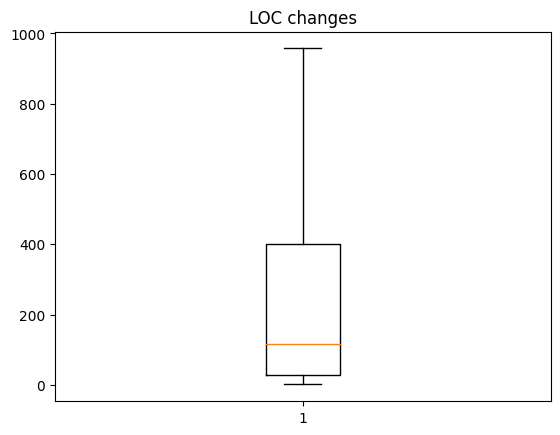

In [40]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('LOC changes')
ax1.boxplot(x=df_commit_diffs_satd.lines, showfliers=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7b6f98d18b50>,
 'caps': [<matplotlib.lines.Line2D at 0x7b6f98d18d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b6f98d1a080>],
 'medians': [<matplotlib.lines.Line2D at 0x7b6f98d19750>],
 'fliers': [],
 'means': []}

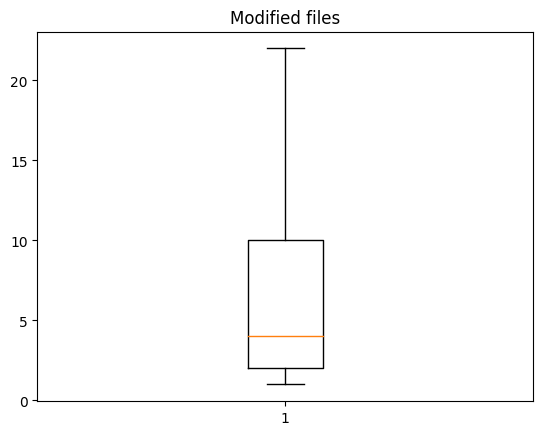

In [41]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('Modified files')
ax1.boxplot(x=df_commit_diffs_satd.files, showfliers=False)

In [42]:
df_commit_diffs_satd.to_excel('commit_diffs_satd.xlsx', index=False)

### Commits with Critical Classes diffs with SATD

In [43]:
print('Conjunto de commits com classes críticas: ')
print(f'{len(set_only_commits_critical_classes)}')

Conjunto de commits com classes críticas: 
4522


In [44]:
df_commits_with_critical_classes_with_satd = df_commit_diffs_satd[df_commit_diffs_satd.commit.isin(set_only_commits_critical_classes)]
df_commits_with_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,74502,344,"[fix, implementation, exception, update, updat...",[\t * Throws an exception if the metrics imple...
2,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,add deletion marker support to Column (boolean...,997,11,"[TODO, TODO]",[ * (TODO: look at making SuperColumn immutabl...
5,66dee7aaab26556561614ab056469ade85de5ebd,finish remove support. Split CFS.resolve() in...,536,8,"[TODO, exception, TODO, exception]",[\t\t\t// TODO: throw a thrift exception if we...
6,a996c8214baa4fa886071a24b8058ed1ca284686,test support. this requires some refactoring ...,1356,26,"[throughput, output, clean, TODO, test, TODO, ...",[ * high throughput on reads but a...
7,20e081f2901384f0786a56fb21a181033aa8e839,consolidates partition behavior in IPartitione...,1263,18,"[TODO, TODO]",[ // TODO this is broken because SST/Se...
...,...,...,...,...,...,...
4326,6708499e4c930f7733894e6076b925fb151d9251,Remove metrics-reporter-config dependency\n\np...,105,10,[dependency],[ * Remove metrics-reporter-config dependency ...
4328,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,289,11,"[exception, not thread safe, exception]",[ /** Should throw exception if null client...
4332,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,724,18,"[files, files, constructor, exception, exception]",[ * Do not create sstable files before registe...
4333,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,237,13,[update],[ * Internode legacy SSL storage port certific...


In [45]:
round(df_commits_with_critical_classes_with_satd.describe(), 2)

,lines,files
count,1734.00,1734.00
mean,1322.96,21.57
std,7459.71,46.47
min,3.00,1.00
25%,72.00,4.00
50%,259.00,9.00
75%,832.00,20.00
max,215675.00,645.00


## Analisa Commits sem SATD

### Analisa todos os diffs (added) dos commits entre 2/03/2009 e 4/10/2023 do Cassandra que SEM as SATD.

In [46]:
dict_commit_diffs_no_satd = my_satd_commit_analyzer.analyze_commit_diffs_for_no_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD diff commit analysis: 100%|██████████| 29230/29230 [14:22<00:00, 33.89it/s]


In [47]:
df_commit_diffs_no_satd = create_df_commits_diffs_no_satd(dict_commit_diffs_no_satd)

In [48]:
df_commit_diffs_no_satd

,commits,msg,lines,files,comments
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,74502,344,"[/**, * Licensed to the Apache Software Found..."
1,cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3,Add build script and make sure it works\n\ngit...,156,4,"[// JobTracker.instance().start();,..."
2,e90036f6e1b2c799bef4842f69a0df9ee5b08ec9,Needed to make these changes to fix an issue w...,183,4,"[ /**, * This method returns true if t..."
3,16f30f16749fe4f75c94b17aa4a4b63df4ddb825,Fixed some bugs that resulted from moving sour...,93,5,[ // seeking outside of current buf...
4,da5c6b8fc6ce179e22fb344a2dd528403fc11385,Removed JDK7 dependencies.\n\ngit-svn-id: http...,144,1,"[ // rm.add(""Test:Column-"" + j,..."
...,...,...,...,...,...
9478,dc7234134cb20af4f10b41eab57bd5312fd0e6f1,Upgrade snappy-java to 1.1.10.4\n\npatch by Ma...,3,2,[ * Upgrade snappy-java to 1.1.10.4 (CASSANDRA...
9479,164fa7949d1437528363465d14ed20898f1daa9e,Add support for repair coordinator to retry me...,8533,140,"[/*, * Licensed to the Apache Software Founda..."
9480,b9f614f7e56b8b12149cb51f89558d0568901853,Remove deprecated properties in CompressionPar...,157,14,[ * Remove deprecated properties in Compressio...
9481,cb1f1399b139029e5b1c12a4bf65d19a55724933,Improve performance of compactions when table ...,79,3,"[ /**, * Returns true if the m..."


In [49]:
round(df_commit_diffs_no_satd.describe(), 2)

,lines,files
count,9483.00,9483.00
mean,421.46,8.46
std,3377.66,23.77
min,1.00,1.00
25%,15.00,2.00
50%,59.00,3.00
75%,206.00,7.00
max,215675.00,645.00


In [50]:
df_commit_diffs_no_satd.to_excel('commit_diffs_no_satd.xlsx', index=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7b6f97bd5b10>,
 'caps': [<matplotlib.lines.Line2D at 0x7b6f97bd4fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b6f97bd7c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7b6f97bd5210>],
 'fliers': [],
 'means': []}

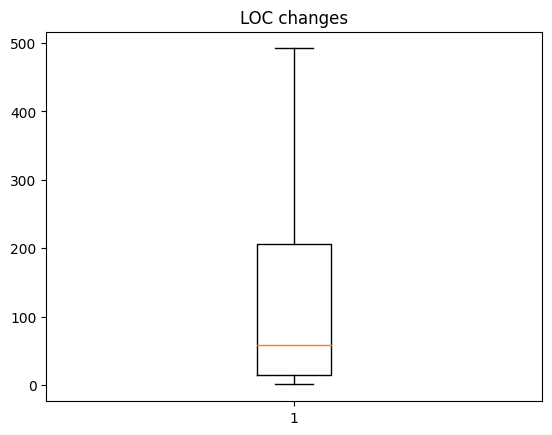

In [51]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('LOC changes')
ax1.boxplot(x=df_commit_diffs_no_satd.lines, showfliers=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7b6f911abdf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b6f911aa5c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b6f911a8460>],
 'medians': [<matplotlib.lines.Line2D at 0x7b6f911a8f40>],
 'fliers': [],
 'means': []}

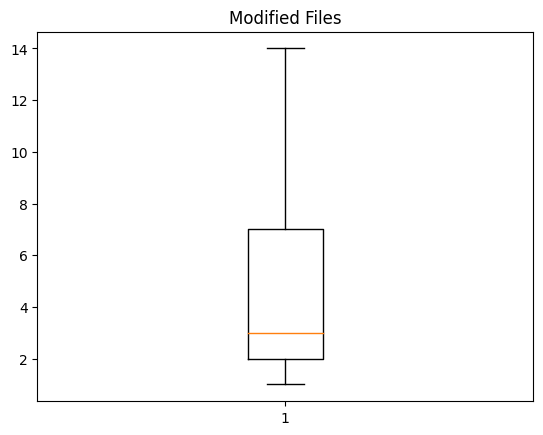

In [52]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('Modified Files')
ax1.boxplot(x=df_commit_diffs_no_satd.files, showfliers=False)

In [53]:
df_commits_with_critical_classes_no_satd = df_commit_diffs_no_satd[df_commit_diffs_no_satd.commits.isin(set_only_commits_critical_classes)]
df_commits_with_critical_classes_no_satd

,commits,msg,lines,files,comments
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,74502,344,"[/**, * Licensed to the Apache Software Found..."
1,cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3,Add build script and make sure it works\n\ngit...,156,4,"[// JobTracker.instance().start();,..."
9,39d3f833f9c4e154eb157336f5e7b2a1ce9a79a3,add SuperColumn support to forceFlush. split ...,89,5,[ * Compares two Memtable based on creatio...
11,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,add deletion marker support to Column (boolean...,997,11,"[ * Column is immutable, which prevents all ki..."
13,66dee7aaab26556561614ab056469ade85de5ebd,finish remove support. Split CFS.resolve() in...,536,8,[ /* Check if MemtableManager has a...
...,...,...,...,...,...
9454,8bbf92a670d98f758c549cf241e7732370c21384,Refactor validation logic in StorageService.re...,33,2,[ * Refactor validation logic in StorageServic...
9468,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,289,11,[ * Add the ability to disable bulk loading of...
9473,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,724,18,[ // We need to ensure that no sstable ...
9474,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,237,13,[ // Initialize hot reloading here ...


In [54]:
round(df_commits_with_critical_classes_no_satd.describe(), 2)

,lines,files
count,3256.00,3256.00
mean,790.89,15.26
std,5485.86,36.73
min,2.00,1.00
25%,37.00,3.00
50%,126.00,6.00
75%,394.00,13.00
max,215675.00,645.00


# Comparing Commits with SATD and Commits without SATD


## Geral

In [159]:
df_commit_diffs_satd

,commit,msg,lines,files,keywords,comments
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,74502,344,"[fix, implementation, exception, update, updat...",[\t * Throws an exception if the metrics imple...
1,82f5b6072a283d6742b7783e2d856c1d2c0e1f39,New thrift file added\n\ngit-svn-id: https://s...,92,1,[API],[ // The following are beta APIs being introd...
2,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,add deletion marker support to Column (boolean...,997,11,"[TODO, TODO]",[ * (TODO: look at making SuperColumn immutabl...
3,abc75388a3df8de72b28a5edb830e1c19ed9ec80,fix crash when comparing supercolumns (since t...,192,1,"[test, test]",[ /* inverse sort by time to get hte la...
4,def1edd1fe90a4a9c9eef4ef26f422ba3a21d28f,send back response so blocking calls can work\...,145,2,[TODO],[ // TODO shouldn't this be checked...
...,...,...,...,...,...,...
4334,3c767b0d6d8538b8dab4870052d4fd1a092a62a2,SAI docs for CEP-7\n\n patch by Lorina Poland;...,7003,212,"[test, documentation, dependencies, test, upda...",[*** xref:master@_:ROOT:development/testing.ad...
4335,b58d8f174d4c1017d54d4b8bdb8a0a6c592f1655,Make the output of ON/OFF commands in cqlsh co...,153,3,[output],[ * Make the output of ON/OFF commands in cqls...
4336,164fa7949d1437528363465d14ed20898f1daa9e,Add support for repair coordinator to retry me...,8533,140,"[support for, test, test, speed up, speed, cle...",[ * Add support for repair coordinator to retr...
4337,cb1f1399b139029e5b1c12a4bf65d19a55724933,Improve performance of compactions when table ...,79,3,"[performance, speed up, speed]",[ * Improve performance of compactions when ta...


In [160]:
df_commit_diffs_satd.to_excel('commit_diffs_satd.xlsx', index=False)
df_commit_diffs_no_satd.to_excel('commit_diffs_no_satd.xlsx', index=False)

### LOC changes

<ipython-input-150-1df2d80da97b>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])


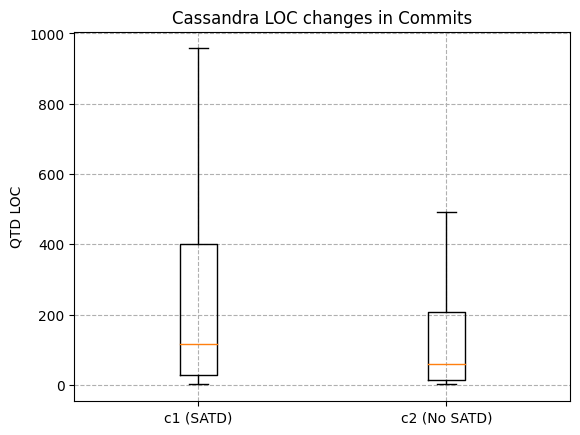

In [150]:
data_lines = [df_commit_diffs_satd.lines, df_commit_diffs_no_satd.lines]

fig1, ax1 = pyplot.subplots()

ax1.set_title('Cassandra LOC changes in Commits')
ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_lines, showfliers=False)

fig1.savefig('cassandra1.png')
Image1 = cv2.imread('cassandra1.png')
list_figures.append(Image1)
list_titles.append('Cassandra LOC changes in Commits')

### Modified Files

<ipython-input-151-cda750b5e7b6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])


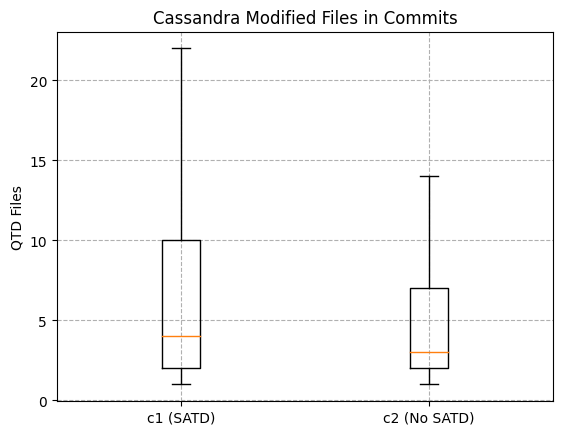

In [151]:
data_lines = [df_commit_diffs_satd.files, df_commit_diffs_no_satd.files]
fig1, ax1 = pyplot.subplots()

ax1.set_title('Cassandra Modified Files in Commits')
ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_lines, showfliers=False)

fig1.savefig('cassandra2.png')
Image2 = cv2.imread('cassandra2.png')
list_figures.append(Image2)
list_titles.append('Cassandra Modified Files in Commits')

## Commits with Critical Classes

### Geral

In [161]:
df_commits_with_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,74502,344,"[fix, implementation, exception, update, updat...",[\t * Throws an exception if the metrics imple...
2,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,add deletion marker support to Column (boolean...,997,11,"[TODO, TODO]",[ * (TODO: look at making SuperColumn immutabl...
5,66dee7aaab26556561614ab056469ade85de5ebd,finish remove support. Split CFS.resolve() in...,536,8,"[TODO, exception, TODO, exception]",[\t\t\t// TODO: throw a thrift exception if we...
6,a996c8214baa4fa886071a24b8058ed1ca284686,test support. this requires some refactoring ...,1356,26,"[throughput, output, clean, TODO, test, TODO, ...",[ * high throughput on reads but a...
7,20e081f2901384f0786a56fb21a181033aa8e839,consolidates partition behavior in IPartitione...,1263,18,"[TODO, TODO]",[ // TODO this is broken because SST/Se...
...,...,...,...,...,...,...
4326,6708499e4c930f7733894e6076b925fb151d9251,Remove metrics-reporter-config dependency\n\np...,105,10,[dependency],[ * Remove metrics-reporter-config dependency ...
4328,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,289,11,"[exception, not thread safe, exception]",[ /** Should throw exception if null client...
4332,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,724,18,"[files, files, constructor, exception, exception]",[ * Do not create sstable files before registe...
4333,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,237,13,[update],[ * Internode legacy SSL storage port certific...


In [162]:
df_commits_with_critical_classes_with_satd.to_excel('commits_with_critical_classes_with_satd.xlsx', index=False)
df_commits_with_critical_classes_no_satd.to_excel('commits_with_critical_classes_no_satd.xlsx', index=False)

**LOC changes**

<ipython-input-152-f55247ebd1d5>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])


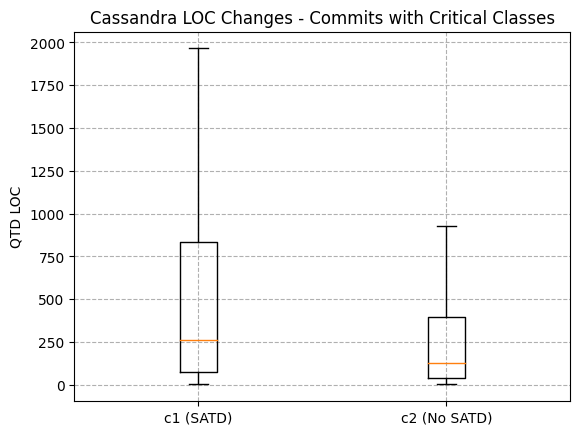

In [152]:
data_commits_cc_lines = df_commits_with_critical_classes_with_satd.lines, df_commits_with_critical_classes_no_satd.lines
fig1, ax1 = pyplot.subplots()

ax1.set_title('Cassandra LOC Changes - Commits with Critical Classes')
ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_commits_cc_lines, showfliers=False)

fig1.savefig('cassandra3.png')
Image3 = cv2.imread('cassandra3.png')
list_figures.append(Image3)
list_titles.append('Cassandra LOC Changes - Commits with Critical Classes')

**Modified files**

<ipython-input-153-6be7c63e1ab0>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])


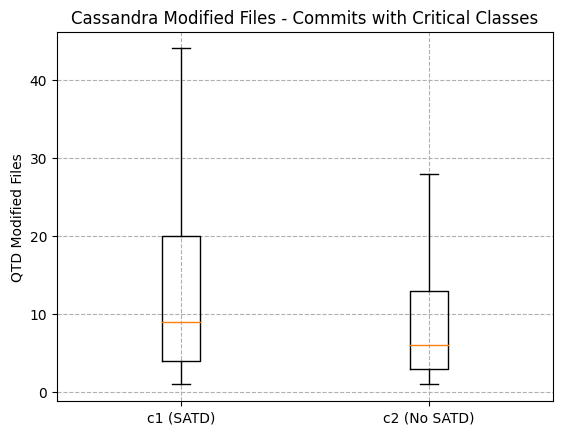

In [153]:
data_commits_cc_files = df_commits_with_critical_classes_with_satd.files, df_commits_with_critical_classes_no_satd.files

fig1, ax1 = pyplot.subplots()

ax1.set_title('Cassandra Modified Files - Commits with Critical Classes')
ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])
ax1.set_ylabel('QTD Modified Files')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_commits_cc_files, showfliers=False)

fig1.savefig('cassandra4.png')
Image4 = cv2.imread('cassandra4.png')
list_figures.append(Image4)
list_titles.append('Cassandra Modified Files - Commits with Critical Classes')

### Issues in commits

In [59]:
df_issues_in_commits_with_critical_classes_with_satd = df_commits_with_critical_classes_with_satd[df_commits_with_critical_classes_with_satd.commit.isin(list_commits_with_critical_classes_with_issues)]
df_issues_in_commits_with_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
34,907d92e21b8ce79e6a224933764e3b7215a94454,replace BigInteger tokens with BigIntegerToken...,1090,31,"[files, test, TODO]",[\t \t //if( !isLoop...
35,296e15b63cdb678a12db004e29359eaf8c14c6c5,add test for ReplicaPlacementStrategy covering...,77,3,[endpoints],[ // make sure that the Strategy picks the ...
37,9db8da81b7f269e5a8a7f896b751d482847d7082,"Add range query support, which requires using ...",1456,19,"[interface, interface, TODO, TODO]",[ * Do not mix with calls to the iterator ...
39,219293b2b35453320c78514f9de7724da164638e,clean up logging. move some of it into MBeans...,493,9,[TODO],[ // TODO send more requests if we ...
41,c3f0d10a8e22cc9a4f76b88ec647a1075f322e0a,clean up more ad-hoc timing message and move t...,354,9,[latency],[ * @return average latency per read opera...
...,...,...,...,...,...,...
4326,6708499e4c930f7733894e6076b925fb151d9251,Remove metrics-reporter-config dependency\n\np...,105,10,[dependency],[ * Remove metrics-reporter-config dependency ...
4328,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,289,11,"[exception, not thread safe, exception]",[ /** Should throw exception if null client...
4332,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,724,18,"[files, files, constructor, exception, exception]",[ * Do not create sstable files before registe...
4333,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,237,13,[update],[ * Internode legacy SSL storage port certific...


In [164]:
df_issues_in_commits_with_critical_classes_with_satd.to_excel('issues_in_commits_with_critical_classes_with_satd.xlsx', index=False)

In [60]:
round(df_issues_in_commits_with_critical_classes_with_satd.describe(), 2)

,lines,files
count,1496.00,1496.00
mean,1406.44,22.33
std,7790.30,46.98
min,3.00,1.00
25%,76.75,4.00
50%,274.00,9.00
75%,879.50,21.00
max,215675.00,645.00


In [61]:
df_issues_in_commits_with_critical_classes_no_satd = df_commits_with_critical_classes_no_satd[df_commits_with_critical_classes_no_satd.commits.isin(list_commits_with_critical_classes_with_issues)]
df_issues_in_commits_with_critical_classes_no_satd

,commits,msg,lines,files,comments
86,907d92e21b8ce79e6a224933764e3b7215a94454,replace BigInteger tokens with BigIntegerToken...,1090,31,"[/**, * Licensed to the Apache Software Found..."
87,296e15b63cdb678a12db004e29359eaf8c14c6c5,add test for ReplicaPlacementStrategy covering...,77,3,[ // render a String representation of ...
88,bfb2e952204f9879133826305b2b5dfda3e61776,rename getDefaultToken -> getInitialToken\npat...,30,9,"[ /**, * @return the token to use for ..."
90,9db8da81b7f269e5a8a7f896b751d482847d7082,"Add range query support, which requires using ...",1456,19,[ // Returns true if field tablename is set...
94,bcf4dcc666694b80b4ead2adb4a02486f9078e75,refactor HttpConnection to use its own executo...,138,4,"[ // handle the get request type, ..."
...,...,...,...,...,...
9454,8bbf92a670d98f758c549cf241e7732370c21384,Refactor validation logic in StorageService.re...,33,2,[ * Refactor validation logic in StorageServic...
9468,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,289,11,[ * Add the ability to disable bulk loading of...
9473,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,724,18,[ // We need to ensure that no sstable ...
9474,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,237,13,[ // Initialize hot reloading here ...


In [62]:
round(df_issues_in_commits_with_critical_classes_no_satd.describe(), 2)

,lines,files
count,2790.00,2790.00
mean,830.90,15.37
std,5744.42,35.78
min,2.00,1.00
25%,40.00,3.00
50%,131.00,6.00
75%,404.75,14.00
max,215675.00,645.00


In [165]:
df_issues_in_commits_with_critical_classes_no_satd.to_excel('issues_in_commits_with_critical_classes_no_satd.xlsx', index=False)

**LOC changes**

<ipython-input-154-d276349afc1b>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])


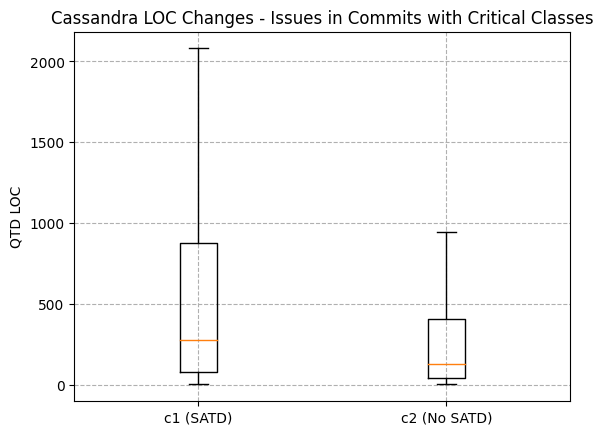

In [154]:
data_issues_commits_cc_lines = df_issues_in_commits_with_critical_classes_with_satd.lines, df_issues_in_commits_with_critical_classes_no_satd.lines
fig1, ax1 = pyplot.subplots()

ax1.set_title('Cassandra LOC Changes - Issues in Commits with Critical Classes')
ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_issues_commits_cc_lines, showfliers=False)

fig1.savefig('cassandra5.png')
Image5 = cv2.imread('cassandra5.png')
list_figures.append(Image5)
list_titles.append('Cassandra LOC Changes - Issues in Commits with Critical Classes')

**Modified Files**

<ipython-input-155-53ff2a9aa6a4>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])


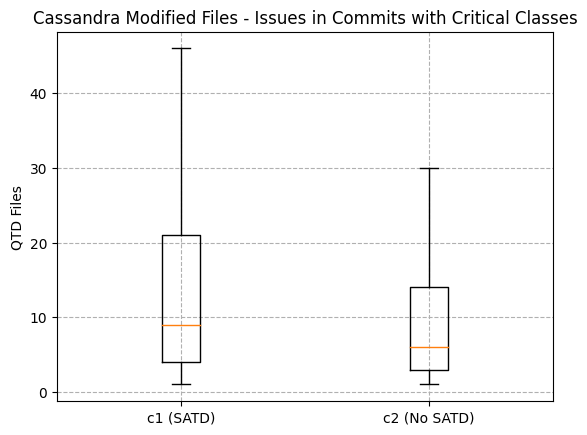

In [155]:
data_issues_commits_cc_files = df_issues_in_commits_with_critical_classes_with_satd.files, df_issues_in_commits_with_critical_classes_no_satd.files
fig1, ax1 = pyplot.subplots()

ax1.set_title('Cassandra Modified Files - Issues in Commits with Critical Classes')
ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_issues_commits_cc_files, showfliers=False)

fig1.savefig('cassandra6.png')
Image6 = cv2.imread('cassandra6.png')
list_figures.append(Image6)
list_titles.append('Cassandra Modified Files - Issues in Commits with Critical Classes')

## Commits without Critical Classes

In [65]:
print('Commits sem classes críticas', len(list_commits_no_critical_classes))

Commits sem classes críticas 24708


In [66]:
dict_commits_no_critical_classes = {}
for k, v in all_commits.items():
  if k in list_commits_no_critical_classes:
    dict_commits_no_critical_classes[k] = v

print(len(dict_commits_no_critical_classes))

24708


In [67]:
df_commits_no_critical_classes = convert_commits_to_dataframe2(dict_commits_no_critical_classes)
df_commits_no_critical_classes

,hash,msg,date,lines,files,modified_files,diff_modified_files
0,4d09e9562df2548f9a1a42c4c78f1132a858e678,Sample config file.\n\ngit-svn-id: https://svn...,14/3/2009,40,1,[storage-conf.xml],"[{'storage-conf.xml': '@@ -0,0 +1,40 @@ +<Stor..."
1,e90036f6e1b2c799bef4842f69a0df9ee5b08ec9,Needed to make these changes to fix an issue w...,18/3/2009,183,4,"[ChecksumManager.java, ChecksumRandomAccessFil...","[{'ChecksumManager.java': '@@ -53,7 +53,7 @@ i..."
2,16f30f16749fe4f75c94b17aa4a4b63df4ddb825,Fixed some bugs that resulted from moving sour...,19/3/2009,93,5,"[AIORandomAccessFile.java, BufferedRandomAcces...","[{'AIORandomAccessFile.java': '@@ -656,50 +656..."
3,283f3a08755f0f1d121c87a25ee7679b64d35d8b,Removed references to JDK7 specific classes.\n...,20/3/2009,813,2,"[AIORandomAccessFile.java, SequenceFile.java]","[{'AIORandomAccessFile.java': '@@ -1,745 +0,0 ..."
4,ff2cf35afff5a0735b1f6410f44a2a59cb7a5ca9,Removed the dependencies for JDK7.\n\ngit-svn-...,20/3/2009,23,1,[CommitLog.java],"[{'CommitLog.java': '@@ -19,7 +19,6 @@ packag..."
...,...,...,...,...,...,...,...
24703,c60b2ca65f85f2502453bc35a11e656e6eddd9b1,Merge branch 'cassandra-5.0' into trunk,3/10/2023,3,2,[],[]
24704,d828cd0228143438590f3aaa4e2c7d3c03bd66d8,Test failure: org.apache.cassandra.repair.Conc...,3/10/2023,3,1,[ConcurrentIrWithPreviewFuzzTest.java],[{'ConcurrentIrWithPreviewFuzzTest.java': '@@ ...
24705,16b43e4d4bd4b49029c0fc360bae1e732a7d5aae,Merge branch 'cassandra-5.0' into trunk,3/10/2023,3,1,[],[]
24706,eb30005251cd8c10732ecab8365ebaa45f5fcbde,Upgrade caffeine cache and fix CIDR permission...,3/10/2023,18,6,"[parent-pom-template.xml, CHANGES.txt, AuthCac...","[{'parent-pom-template.xml': '@@ -1015,7 +1015..."


In [68]:
round(df_commits_no_critical_classes.describe(), 2)

,lines,files
count,24708.00,24708.00
mean,143.63,3.75
std,984.68,10.24
min,0.00,0.00
25%,3.00,1.00
50%,14.00,2.00
75%,66.00,4.00
max,62756.00,547.00


In [166]:
df_commits_no_critical_classes.to_excel('commits_no_critical_classes.xlsx', index=False)

In [69]:
list_commits_no_critical_classes = df_commits_no_critical_classes.hash.to_list()
print(len(list_commits_no_critical_classes))

24708


### Commits sem critical classes com SATD

In [70]:
df_commits_without_critical_classes_with_satd = df_commit_diffs_satd[df_commit_diffs_satd.commit.isin(list_commits_no_critical_classes)]
df_commits_without_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
1,82f5b6072a283d6742b7783e2d856c1d2c0e1f39,New thrift file added\n\ngit-svn-id: https://s...,92,1,[API],[ // The following are beta APIs being introd...
3,abc75388a3df8de72b28a5edb830e1c19ed9ec80,fix crash when comparing supercolumns (since t...,192,1,"[test, test]",[ /* inverse sort by time to get hte la...
4,def1edd1fe90a4a9c9eef4ef26f422ba3a21d28f,send back response so blocking calls can work\...,145,2,[TODO],[ // TODO shouldn't this be checked...
11,f5d1a1289c88dcefd226e9ffcca2a1cd2d145892,Changes in here to enable multiget() support.\...,99,3,[header],[ /* Do read repair if header of th...
17,9049d5919dfcfca6a536caa9007172d01a2730b4,fix crash when comparing supercolumns (since t...,192,1,"[test, test]",[ /* inverse sort by time to get hte la...
...,...,...,...,...,...,...
4331,3658ba58c7d0be0803cbd7480c73d46705c3372d,JMH improvements - faster build and async prof...,446,12,"[improvement, test, test]",[ * JMH improvements - faster build and async ...
4334,3c767b0d6d8538b8dab4870052d4fd1a092a62a2,SAI docs for CEP-7\n\n patch by Lorina Poland;...,7003,212,"[test, documentation, dependencies, test, upda...",[*** xref:master@_:ROOT:development/testing.ad...
4335,b58d8f174d4c1017d54d4b8bdb8a0a6c592f1655,Make the output of ON/OFF commands in cqlsh co...,153,3,[output],[ * Make the output of ON/OFF commands in cqls...
4337,cb1f1399b139029e5b1c12a4bf65d19a55724933,Improve performance of compactions when table ...,79,3,"[performance, speed up, speed]",[ * Improve performance of compactions when ta...


In [71]:
round(df_commits_without_critical_classes_with_satd.describe(), 2)

,lines,files
count,2605.00,2605.00
mean,345.10,6.37
std,1303.18,15.54
min,1.00,1.00
25%,16.00,2.00
50%,69.00,3.00
75%,225.00,6.00
max,34563.00,510.00


In [167]:
df_commits_without_critical_classes_with_satd.to_excel('commits_without_critical_classes_with_satd.xlsx', index=False)

### Commits sem critical classes e sem SATD

In [72]:
df_commits_without_critical_classes_no_satd = df_commit_diffs_no_satd[df_commit_diffs_no_satd.commits.isin(list_commits_no_critical_classes)]
df_commits_without_critical_classes_no_satd

,commits,msg,lines,files,comments
2,e90036f6e1b2c799bef4842f69a0df9ee5b08ec9,Needed to make these changes to fix an issue w...,183,4,"[ /**, * This method returns true if t..."
3,16f30f16749fe4f75c94b17aa4a4b63df4ddb825,Fixed some bugs that resulted from moving sour...,93,5,[ // seeking outside of current buf...
4,da5c6b8fc6ce179e22fb344a2dd528403fc11385,Removed JDK7 dependencies.\n\ngit-svn-id: http...,144,1,"[ // rm.add(""Test:Column-"" + j,..."
5,74dcfb263ca695534ec631d8cf11f909e54a9765,Fix for CASSANDRA-9 JIRA. \n\ngit-svn-id: http...,36,1,"[ /**, * Flushes the current memtable ..."
6,82f5b6072a283d6742b7783e2d856c1d2c0e1f39,New thrift file added\n\ngit-svn-id: https://s...,92,1,[ // Get the specified key into buffercache f...
...,...,...,...,...,...
9477,a580b79d1668ddbe4d462bf6fcac07835a72a9f3,Upgrade slf4j-api to 1.7.36\n\nPatch by mmuzaf...,7,2,[ * Upgrade slf4j-api to 1.7.36 (CASSANDRA-188...
9478,dc7234134cb20af4f10b41eab57bd5312fd0e6f1,Upgrade snappy-java to 1.1.10.4\n\npatch by Ma...,3,2,[ * Upgrade snappy-java to 1.1.10.4 (CASSANDRA...
9480,b9f614f7e56b8b12149cb51f89558d0568901853,Remove deprecated properties in CompressionPar...,157,14,[ * Remove deprecated properties in Compressio...
9481,cb1f1399b139029e5b1c12a4bf65d19a55724933,Improve performance of compactions when table ...,79,3,"[ /**, * Returns true if the m..."


In [73]:
round(df_commits_without_critical_classes_no_satd.describe(), 2)

,lines,files
count,6227.00,6227.00
mean,228.30,4.90
std,1237.95,10.86
min,1.00,1.00
25%,10.00,2.00
50%,39.00,3.00
75%,133.00,5.00
max,62756.00,510.00


In [168]:
df_commits_without_critical_classes_no_satd.to_excel('commits_without_critical_classes_no_satd.xlsx', index=False)

### Testes dos commits sem critical classes

**LOC changes**

<ipython-input-156-d803fd2815ef>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])


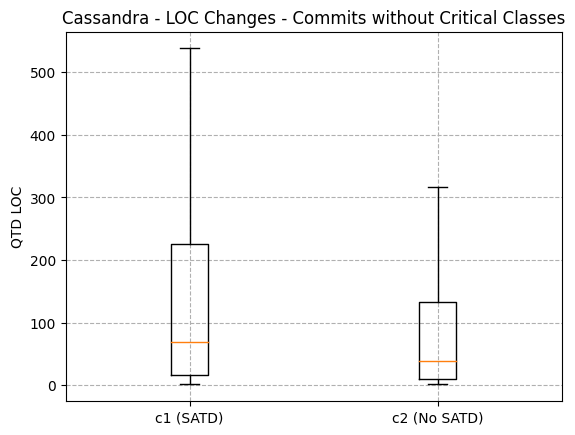

In [156]:
data_commits_no_cc_lines = df_commits_without_critical_classes_with_satd.lines, df_commits_without_critical_classes_no_satd.lines

fig1, ax1 = pyplot.subplots()

ax1.set_title('Cassandra - LOC Changes - Commits without Critical Classes')
ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_commits_no_cc_lines, showfliers=False)

fig1.savefig('cassandra7.png')
Image7 = cv2.imread('cassandra7.png')
list_figures.append(Image7)
list_titles.append('Cassandra - LOC Changes - Commits without Critical Classes')

**Modified Files**

<ipython-input-157-7da7e20eb320>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])


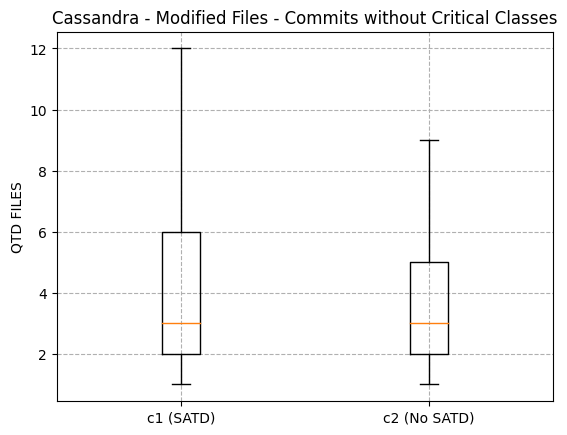

In [157]:
data_commits_no_cc_files = df_commits_without_critical_classes_with_satd.files, df_commits_without_critical_classes_no_satd.files

fig1, ax1 = pyplot.subplots()

ax1.set_title('Cassandra - Modified Files - Commits without Critical Classes')
ax1.set_xticklabels(['c1 (SATD)', 'c2 (No SATD)'])
ax1.set_ylabel('QTD FILES')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_commits_no_cc_files, showfliers=False)

fig1.savefig('cassandra8.png')
Image8 = cv2.imread('cassandra8.png')
list_figures.append(Image8)
list_titles.append('Cassandra - Modified Files - Commits without Critical Classes')

# Comparing Boxsplot of Commits with SATD and Commits without SATD

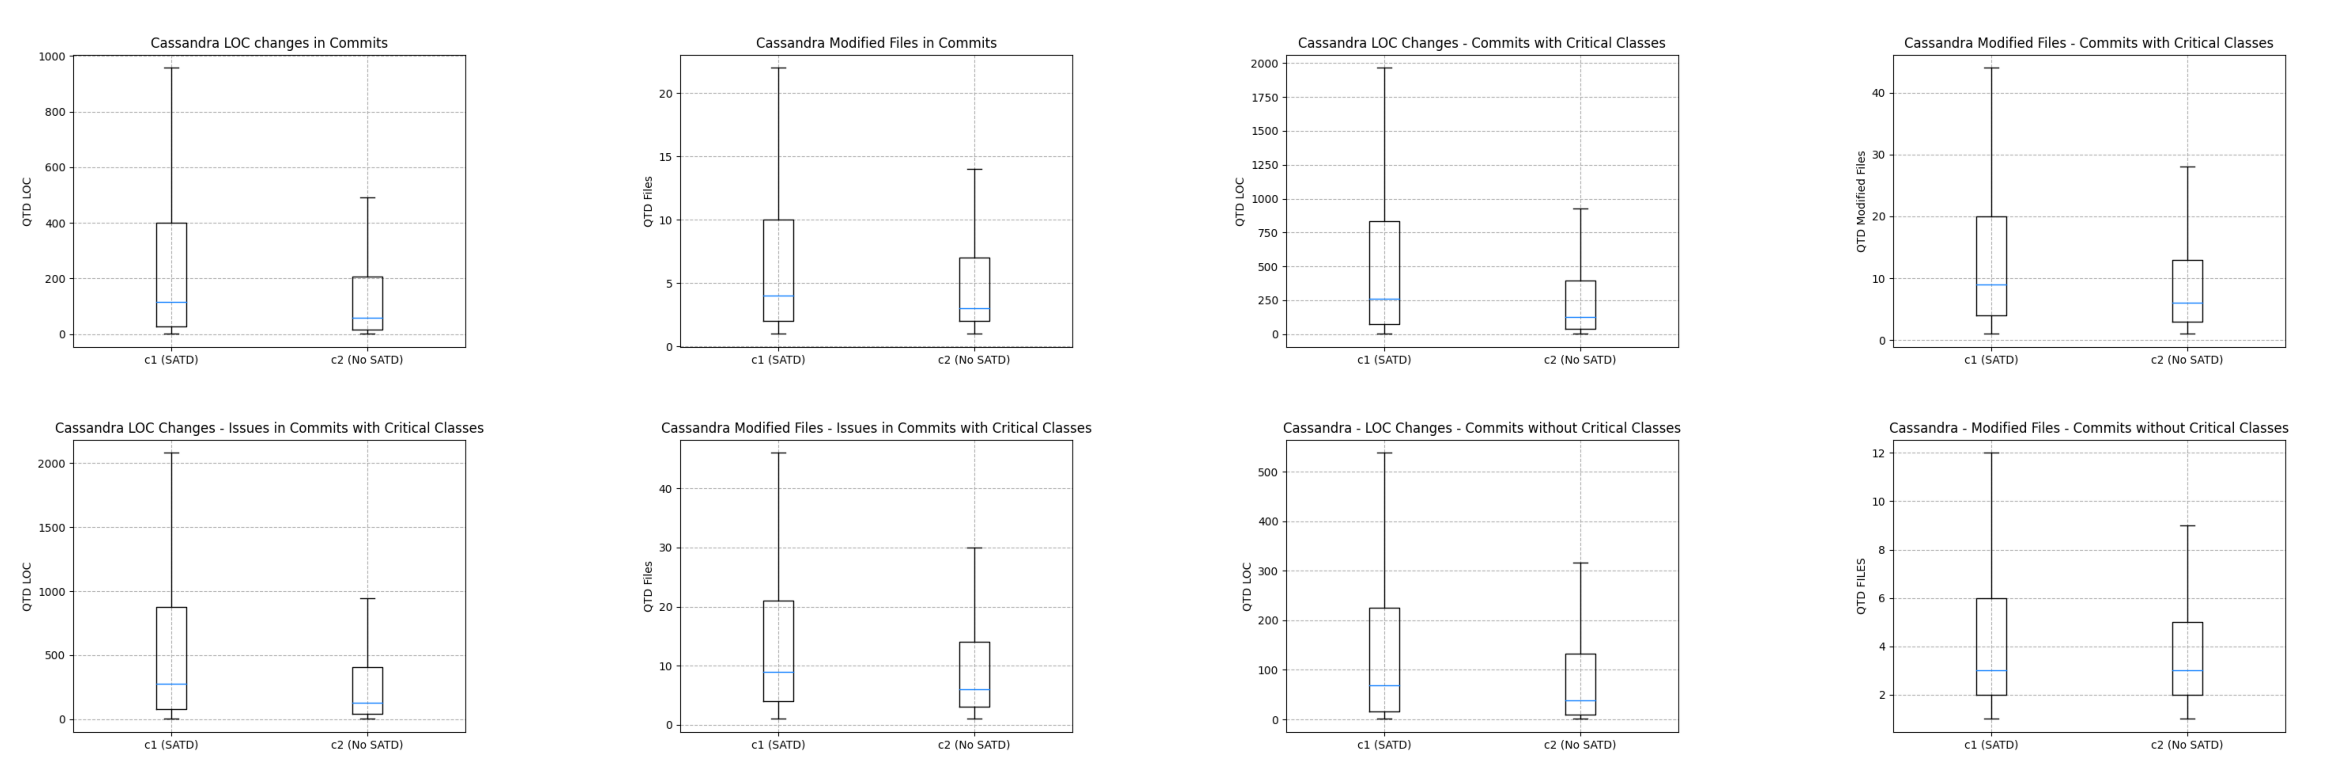

In [158]:
my_figures(lista_imagens=list_figures, my_h=30, my_w=10, my_hspace=0, my_wspace=0.2)